# Test beam analysis

### Necessary Imports

In [1]:
import os
import uproot
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import norm, moyal
from scipy.signal import find_peaks

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100000

### Read the nTuple data into a Pandas DataFrame

In [15]:
# Define the custom order for the keys
custom_order = [
    'ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R',
    'TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13',
    'TriggerScint',
    'PbGlass',
    'HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14'
]
    
def ntuple_to_pd(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}:anaTree".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframe
    df = pd.DataFrame()
    for key in main_keys:
        
        # Skip the nChannels key
        if(key == 'nChannels'):
            continue

        arr = events[key].array(library='np').squeeze()

        # Convert the array to a DataFrame
        df_key = pd.DataFrame(arr)

        # Rename the columns to include the key name
        df_key.columns = [f"{key}{i}" for i in df_key.columns]

        # Concatenate the new DataFrame to the existing one
        df = pd.concat([df, df_key], axis=1)
        
    return df

def ntuple_to_pd_multipeak(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframes for each detector element.
    df_dict = {}
    for key in main_keys:
        
        key_noversion = key.split(';')[0]
        
        # Skip the EventInfo key
        if(key_noversion == 'EventInfo'):
            continue
        
        print("Processing dataframe for",key,"...")
        
        # Get the number of peaks and timestamps
        nPeaks        = events[key]['nPeaks'].array()
        timeStamp     = events[key]['timeStamp'].array()
        triggerTime   = events[key]['triggerTime'].array()
        Pedestal      = events[key]['Pedestal'].array()
        PedestalSigma = events[key]['PedestalSigma'].array()
        PeakVoltage   = events[key]['PeakVoltage'].array()
        PeakTime      = events[key]['PeakTime'].array()
        SignalTime    = events[key]['SignalTime'].array()
        IntCharge     = events[key]['IntCharge'].array()
        
        # Iterate through the array elements and save information for each peak.
        l_evt, l_ipk, l_nPeaks, l_timeStamp, l_triggerTime = [], [], [], [], []
        l_Pedestal, l_PedestalSigma = [], []
        l_PeakVoltage, l_PeakTime, l_SignalTime, l_IntCharge = [], [], [], []
        for evt, (npk, tstamp, ttime, pedestal, spedestal, pkv, pkt, sigt, chg) in enumerate(zip(nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge)):
            
            # Update the lists for each peak.
            if(npk == 0):
                l_evt.append(evt)
                l_ipk.append(-1)
                l_nPeaks.append(npk)
                l_timeStamp.append(tstamp)
                l_triggerTime.append(ttime)
                l_Pedestal.append(pedestal)
                l_PedestalSigma.append(spedestal)
                l_PeakVoltage.append(-1)
                l_PeakTime.append(-1)
                l_SignalTime.append(-1)
                l_IntCharge.append(-1)
            else:
                for ipk in range(npk):
                    l_evt.append(evt)
                    l_ipk.append(ipk)
                    l_nPeaks.append(npk)
                    l_timeStamp.append(tstamp)
                    l_triggerTime.append(ttime)
                    l_Pedestal.append(pedestal)
                    l_PedestalSigma.append(spedestal)
                    l_PeakVoltage.append(pkv[ipk])
                    l_PeakTime.append(pkt[ipk])
                    l_SignalTime.append(sigt[ipk])
                    l_IntCharge.append(chg[ipk])
        
        # Create a new dataframe.
        df = pd.DataFrame({'event':  l_evt,
                           'iPeak': l_ipk,
                           'nPeaks': l_nPeaks,
                           'timeStamp': l_timeStamp,
                           'triggerTime': l_triggerTime,
                           'Pedestal': l_Pedestal,
                           'PedestalSigma': l_PedestalSigma,
                           'PeakVoltage': l_PeakVoltage,
                           'PeakTime': l_PeakTime,
                           'SignalTime': l_SignalTime,
                           'IntCharge': l_IntCharge
                          })

        # Set this as the dataframe or concatenate it to the one that is already there.
        if(key_noversion in df_dict):
            last_evt = df_dict[key_noversion]['event'].values[-1]+1
            df['event'] = df['event'] + last_evt
            print("Concatenating to",key_noversion,"starting with event number",last_evt)
            df_dict[key_noversion] = pd.concat([df_dict[key_noversion], df], ignore_index=True)
        else:
            df_dict[key_noversion] = df
            
    # Add EventInfo information.
    df = pd.DataFrame( {'RunNumber':   events['EventInfo']['RunNumber'].array(library='np'),
                        'EventNumber': events['EventInfo']['EventNumber'].array(library='np'),
                        'SpillNumber': events['EventInfo']['SpillNumber'].array(library='np')})
    df_dict['EventInfo'] = df
        
    return df_dict

def plot_histograms_for_each_signal(df_dict, base_dir=".", rnum = 0, quantity='nPeaks', select_nonzero_peaks=False, logscale=False):
    
    out_dir = f"{base_dir}/{rnum}"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Create a grid of 8 rows x 4 columns
    fig, axes = plt.subplots(8, 4, figsize=(16, 24))
    flat_axes = axes.ravel()

    # Iterate based on the custom order
    for key, ax in zip(custom_order, flat_axes):
        df = df_dict[key]
        
        # Select only non-zero peaks if specified.
        if(select_nonzero_peaks):
            df_select = df[df['nPeaks'] > 0]
        else:
            df_select = df

        # Plot histogram for the current signal on its corresponding axis
        n, bins, patches = ax.hist(df_select[quantity], bins=20, edgecolor='black', alpha=0.7, label=key)  # capture output to use in legend
        #ax.set_title(key)
        ax.set_xlabel(quantity)
        ax.set_ylabel('Counts/bin')
        ax.legend()  # Add legend
        
        if(logscale):
            ax.set_yscale('log')

    # Adjust the layout so the plots do not overlap
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"{out_dir}/{quantity}.pdf", bbox_inches='tight')

def read_dataframes_from_csv(directory):
    file_names = os.listdir(directory)
    dfs = {}
    for file in file_names:
        if file.endswith('.csv'):
            key = file.split('.csv')[0]
            dfs[key] = pd.read_csv(os.path.join(directory, file))
    return dfs

def compute_statistics(df):
    stats = {
        'avg_nPeaks': df['nPeaks'].mean(),
        'avg_Pedestal': df['Pedestal'].mean(),
        'avg_PedestalSigma': df['PedestalSigma'].mean(),
        'peak_PeakVoltage': df['PeakVoltage'].value_counts().idxmax(),
        'peak_PeakTime': df['PeakTime'].value_counts().idxmax(),
        'peak_SignalTime': df['SignalTime'].value_counts().idxmax(),
        'peak_IntCharge': df['IntCharge'].value_counts().idxmax()
    }
    return stats

def plot_statistics_vs_run(statistics_data, statistic_key, signal_set):
    plt.figure(figsize=(15,8))
    for key in signal_set:
        runs = list(statistics_data.keys())
        values = [statistics_data[run][key][statistic_key] for run in runs]
        plt.plot(runs, values, marker='s', label=key)
    
    plt.title(f"{statistic_key} vs. Run Number")
    plt.xlabel("Run Number")
    plt.ylabel(statistic_key)
    plt.legend()
    plt.grid(True)
    plt.show()

### Create dataframes for all runs

In [5]:
ntuple_dir = "/home/jrenner/local/data/beamtest/ntuple_files/"
ntuple_pd_dir = "/home/jrenner/local/data/beamtest/ntuple_dataframes/"
runs = np.arange(630,766)
for run in runs:
    ntuple_file = "{}/ntuple_000{}.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = ntuple_to_pd_multipeak(ntuple_file)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

Creating dataframes for run 630 ...
Processing dataframe for ACT0L;1 ...
Processing dataframe for ACT0R;1 ...
Processing dataframe for ACT1L;1 ...
Processing dataframe for ACT1R;1 ...
Processing dataframe for ACT3L;1 ...
Processing dataframe for ACT3R;1 ...
Processing dataframe for TriggerScint;1 ...
Processing dataframe for TOF00;1 ...
Processing dataframe for TOF01;1 ...
Processing dataframe for TOF02;1 ...
Processing dataframe for TOF03;1 ...
Processing dataframe for TOF10;1 ...
Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for PbGlass;1 ...
Processing dataframe for HD8;1 ...
Processing dataframe for HD9;1 ...
Processing dataframe for HD10;1 ...
Processing dataframe for HD11;1 ...
Processing dataframe for HD12;1 ...
Processing dataframe for HD13;1 ...
Processing dataframe for HD14;1 ...
Processing dataframe for HD0;1 ...
Processing dataframe for HD1;1 ...
Processing dataframe for HD2;1 ...
Processi

Processing dataframe for ACT0R;1 ...
Processing dataframe for ACT1L;1 ...
Processing dataframe for ACT1R;1 ...
Processing dataframe for ACT3L;1 ...
Processing dataframe for ACT3R;1 ...
Processing dataframe for TriggerScint;1 ...
Processing dataframe for TOF00;1 ...
Processing dataframe for TOF01;1 ...
Processing dataframe for TOF02;1 ...
Processing dataframe for TOF03;1 ...
Processing dataframe for TOF10;1 ...
Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for TOF00;2 ...
Concatenating to TOF00 starting with event number 20961
Processing dataframe for TOF01;2 ...
Concatenating to TOF01 starting with event number 20961
Processing dataframe for TOF02;2 ...
Concatenating to TOF02 starting with event number 20961
Processing dataframe for TOF03;2 ...
Concatenating to TOF03 starting with event number 20961
Processing dataframe for TOF10;2 ...
Concatenating to TOF10 starting with event number 20961
Processing

Concatenating to ACT0R starting with event number 81855
Processing dataframe for ACT1L;4 ...
Concatenating to ACT1L starting with event number 81855
Processing dataframe for ACT1R;4 ...
Concatenating to ACT1R starting with event number 81855
Processing dataframe for ACT3L;4 ...
Concatenating to ACT3L starting with event number 81855
Processing dataframe for ACT3R;4 ...
Concatenating to ACT3R starting with event number 81855
Processing dataframe for TriggerScint;4 ...
Concatenating to TriggerScint starting with event number 81855
Processing dataframe for TOF00;1 ...
Processing dataframe for TOF01;1 ...
Processing dataframe for TOF02;1 ...
Processing dataframe for TOF03;1 ...
Processing dataframe for TOF10;1 ...
Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for TOF00;2 ...
Concatenating to TOF00 starting with event number 24196
Processing dataframe for TOF01;2 ...
Concatenating to TOF01 starting with ev

Concatenating to ACT0L starting with event number 46536
Processing dataframe for ACT0R;3 ...
Concatenating to ACT0R starting with event number 46536
Processing dataframe for ACT1L;3 ...
Concatenating to ACT1L starting with event number 46536
Processing dataframe for ACT1R;3 ...
Concatenating to ACT1R starting with event number 46536
Processing dataframe for ACT3L;3 ...
Concatenating to ACT3L starting with event number 46536
Processing dataframe for ACT3R;3 ...
Concatenating to ACT3R starting with event number 46536
Processing dataframe for TriggerScint;3 ...
Concatenating to TriggerScint starting with event number 46536
Processing dataframe for ACT0L;4 ...
Concatenating to ACT0L starting with event number 69804
Processing dataframe for ACT0R;4 ...
Concatenating to ACT0R starting with event number 69804
Processing dataframe for ACT1L;4 ...
Concatenating to ACT1L starting with event number 69804
Processing dataframe for ACT1R;4 ...
Concatenating to ACT1R starting with event number 69804


Concatenating to HD2 starting with event number 32203
Processing dataframe for HD3;2 ...
Concatenating to HD3 starting with event number 32203
Processing dataframe for HD4;2 ...
Concatenating to HD4 starting with event number 32203
Processing dataframe for HD5;2 ...
Concatenating to HD5 starting with event number 32203
Processing dataframe for HD6;2 ...
Concatenating to HD6 starting with event number 32203
Processing dataframe for HD7;2 ...
Concatenating to HD7 starting with event number 32203
Processing dataframe for HD0;3 ...
Concatenating to HD0 starting with event number 64406
Processing dataframe for HD1;3 ...
Concatenating to HD1 starting with event number 64406
Processing dataframe for HD2;3 ...
Concatenating to HD2 starting with event number 64406
Processing dataframe for HD3;3 ...
Concatenating to HD3 starting with event number 64406
Processing dataframe for HD4;3 ...
Concatenating to HD4 starting with event number 64406
Processing dataframe for HD5;3 ...
Concatenating to HD5 

Concatenating to ACT0R starting with event number 184560
Processing dataframe for ACT1L;9 ...
Concatenating to ACT1L starting with event number 184560
Processing dataframe for ACT1R;9 ...
Concatenating to ACT1R starting with event number 184560
Processing dataframe for ACT3L;9 ...
Concatenating to ACT3L starting with event number 184560
Processing dataframe for ACT3R;9 ...
Concatenating to ACT3R starting with event number 184560
Processing dataframe for TriggerScint;9 ...
Concatenating to TriggerScint starting with event number 184560
Processing dataframe for ACT0L;10 ...
Concatenating to ACT0L starting with event number 207630
Processing dataframe for ACT0R;10 ...
Concatenating to ACT0R starting with event number 207630
Processing dataframe for ACT1L;10 ...
Concatenating to ACT1L starting with event number 207630
Processing dataframe for ACT1R;10 ...
Concatenating to ACT1R starting with event number 207630
Processing dataframe for ACT3L;10 ...
Concatenating to ACT3L starting with even

Concatenating to TOF13 starting with event number 187767
Processing dataframe for TOF00;11 ...
Concatenating to TOF00 starting with event number 208630
Processing dataframe for TOF01;11 ...
Concatenating to TOF01 starting with event number 208630
Processing dataframe for TOF02;11 ...
Concatenating to TOF02 starting with event number 208630
Processing dataframe for TOF03;11 ...
Concatenating to TOF03 starting with event number 208630
Processing dataframe for TOF10;11 ...
Concatenating to TOF10 starting with event number 208630
Processing dataframe for TOF11;11 ...
Concatenating to TOF11 starting with event number 208630
Processing dataframe for TOF12;11 ...
Concatenating to TOF12 starting with event number 208630
Processing dataframe for TOF13;11 ...
Concatenating to TOF13 starting with event number 208630
Processing dataframe for PbGlass;1 ...
Processing dataframe for HD8;1 ...
Processing dataframe for HD9;1 ...
Processing dataframe for HD10;1 ...
Processing dataframe for HD11;1 ...
Pr

Concatenating to HD3 starting with event number 96846
Processing dataframe for HD4;4 ...
Concatenating to HD4 starting with event number 96846
Processing dataframe for HD5;4 ...
Concatenating to HD5 starting with event number 96846
Processing dataframe for HD6;4 ...
Concatenating to HD6 starting with event number 96846
Processing dataframe for HD7;4 ...
Concatenating to HD7 starting with event number 96846
Processing dataframe for HD0;5 ...
Concatenating to HD0 starting with event number 129128
Processing dataframe for HD1;5 ...
Concatenating to HD1 starting with event number 129128
Processing dataframe for HD2;5 ...
Concatenating to HD2 starting with event number 129128
Processing dataframe for HD3;5 ...
Concatenating to HD3 starting with event number 129128
Processing dataframe for HD4;5 ...
Concatenating to HD4 starting with event number 129128
Processing dataframe for HD5;5 ...
Concatenating to HD5 starting with event number 129128
Processing dataframe for HD6;5 ...
Concatenating t

Concatenating to ACT0L starting with event number 207558
Processing dataframe for ACT0R;10 ...
Concatenating to ACT0R starting with event number 207558
Processing dataframe for ACT1L;10 ...
Concatenating to ACT1L starting with event number 207558
Processing dataframe for ACT1R;10 ...
Concatenating to ACT1R starting with event number 207558
Processing dataframe for ACT3L;10 ...
Concatenating to ACT3L starting with event number 207558
Processing dataframe for ACT3R;10 ...
Concatenating to ACT3R starting with event number 207558
Processing dataframe for TriggerScint;10 ...
Concatenating to TriggerScint starting with event number 207558
Processing dataframe for TOF00;1 ...
Processing dataframe for TOF01;1 ...
Processing dataframe for TOF02;1 ...
Processing dataframe for TOF03;1 ...
Processing dataframe for TOF10;1 ...
Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for TOF00;2 ...
Concatenating to TOF00 sta

Concatenating to TOF11 starting with event number 208450
Processing dataframe for TOF12;11 ...
Concatenating to TOF12 starting with event number 208450
Processing dataframe for TOF13;11 ...
Concatenating to TOF13 starting with event number 208450
Processing dataframe for PbGlass;1 ...
Processing dataframe for HD8;1 ...
Processing dataframe for HD9;1 ...
Processing dataframe for HD10;1 ...
Processing dataframe for HD11;1 ...
Processing dataframe for HD12;1 ...
Processing dataframe for HD13;1 ...
Processing dataframe for HD14;1 ...
Processing dataframe for PbGlass;2 ...
Concatenating to PbGlass starting with event number 29069
Processing dataframe for HD8;2 ...
Concatenating to HD8 starting with event number 29069
Processing dataframe for HD9;2 ...
Concatenating to HD9 starting with event number 29069
Processing dataframe for HD10;2 ...
Concatenating to HD10 starting with event number 29069
Processing dataframe for HD11;2 ...
Concatenating to HD11 starting with event number 29069
Process

Concatenating to HD1 starting with event number 129088
Processing dataframe for HD2;5 ...
Concatenating to HD2 starting with event number 129088
Processing dataframe for HD3;5 ...
Concatenating to HD3 starting with event number 129088
Processing dataframe for HD4;5 ...
Concatenating to HD4 starting with event number 129088
Processing dataframe for HD5;5 ...
Concatenating to HD5 starting with event number 129088
Processing dataframe for HD6;5 ...
Concatenating to HD6 starting with event number 129088
Processing dataframe for HD7;5 ...
Concatenating to HD7 starting with event number 129088
Processing dataframe for HD0;6 ...
Concatenating to HD0 starting with event number 161360
Processing dataframe for HD1;6 ...
Concatenating to HD1 starting with event number 161360
Processing dataframe for HD2;6 ...
Concatenating to HD2 starting with event number 161360
Processing dataframe for HD3;6 ...
Concatenating to HD3 starting with event number 161360
Processing dataframe for HD4;6 ...
Concatenat

Processing dataframe for TOF01;1 ...
Processing dataframe for TOF02;1 ...
Processing dataframe for TOF03;1 ...
Processing dataframe for TOF10;1 ...
Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for TOF00;2 ...
Concatenating to TOF00 starting with event number 20798
Processing dataframe for TOF01;2 ...
Concatenating to TOF01 starting with event number 20798
Processing dataframe for TOF02;2 ...
Concatenating to TOF02 starting with event number 20798
Processing dataframe for TOF03;2 ...
Concatenating to TOF03 starting with event number 20798
Processing dataframe for TOF10;2 ...
Concatenating to TOF10 starting with event number 20798
Processing dataframe for TOF11;2 ...
Concatenating to TOF11 starting with event number 20798
Processing dataframe for TOF12;2 ...
Concatenating to TOF12 starting with event number 20798
Processing dataframe for TOF13;2 ...
Concatenating to TOF13 starting with event number 207

Processing dataframe for HD11;1 ...
Processing dataframe for HD12;1 ...
Processing dataframe for HD13;1 ...
Processing dataframe for HD14;1 ...
Processing dataframe for HD0;1 ...
Processing dataframe for HD1;1 ...
Processing dataframe for HD2;1 ...
Processing dataframe for HD3;1 ...
Processing dataframe for HD4;1 ...
Processing dataframe for HD5;1 ...
Processing dataframe for HD6;1 ...
Processing dataframe for HD7;1 ...
Creating dataframes for run 736 ...
Processing dataframe for ACT0L;1 ...
Processing dataframe for ACT0R;1 ...
Processing dataframe for ACT1L;1 ...
Processing dataframe for ACT1R;1 ...
Processing dataframe for ACT3L;1 ...
Processing dataframe for ACT3R;1 ...
Processing dataframe for TriggerScint;1 ...
Processing dataframe for ACT0L;2 ...
Concatenating to ACT0L starting with event number 22844
Processing dataframe for ACT0R;2 ...
Concatenating to ACT0R starting with event number 22844
Processing dataframe for ACT1L;2 ...
Concatenating to ACT1L starting with event number 2

Concatenating to HD5 starting with event number 28794
Processing dataframe for HD6;2 ...
Concatenating to HD6 starting with event number 28794
Processing dataframe for HD7;2 ...
Concatenating to HD7 starting with event number 28794
Creating dataframes for run 738 ...
Processing dataframe for ACT0L;1 ...
Processing dataframe for ACT0R;1 ...
Processing dataframe for ACT1L;1 ...
Processing dataframe for ACT1R;1 ...
Processing dataframe for ACT3L;1 ...
Processing dataframe for ACT3R;1 ...
Processing dataframe for TriggerScint;1 ...
Processing dataframe for ACT0L;2 ...
Concatenating to ACT0L starting with event number 22778
Processing dataframe for ACT0R;2 ...
Concatenating to ACT0R starting with event number 22778
Processing dataframe for ACT1L;2 ...
Concatenating to ACT1L starting with event number 22778
Processing dataframe for ACT1R;2 ...
Concatenating to ACT1R starting with event number 22778
Processing dataframe for ACT3L;2 ...
Concatenating to ACT3L starting with event number 22778
P

Processing dataframe for TOF10;1 ...
Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for PbGlass;1 ...
Processing dataframe for HD8;1 ...
Processing dataframe for HD9;1 ...
Processing dataframe for HD10;1 ...
Processing dataframe for HD11;1 ...
Processing dataframe for HD12;1 ...
Processing dataframe for HD13;1 ...
Processing dataframe for HD14;1 ...
Processing dataframe for HD0;1 ...
Processing dataframe for HD1;1 ...
Processing dataframe for HD2;1 ...
Processing dataframe for HD3;1 ...
Processing dataframe for HD4;1 ...
Processing dataframe for HD5;1 ...
Processing dataframe for HD6;1 ...
Processing dataframe for HD7;1 ...
Creating dataframes for run 743 ...
Processing dataframe for ACT0L;1 ...
Processing dataframe for ACT0R;1 ...
Processing dataframe for ACT1L;1 ...
Processing dataframe for ACT1R;1 ...
Processing dataframe for ACT3L;1 ...
Processing dataframe for ACT3R;1 ...
Processing dataframe for 

Processing dataframe for TOF11;1 ...
Processing dataframe for TOF12;1 ...
Processing dataframe for TOF13;1 ...
Processing dataframe for PbGlass;1 ...
Processing dataframe for HD8;1 ...
Processing dataframe for HD9;1 ...
Processing dataframe for HD10;1 ...
Processing dataframe for HD11;1 ...
Processing dataframe for HD12;1 ...
Processing dataframe for HD13;1 ...
Processing dataframe for HD14;1 ...
Processing dataframe for HD0;1 ...
Processing dataframe for HD1;1 ...
Processing dataframe for HD2;1 ...
Processing dataframe for HD3;1 ...
Processing dataframe for HD4;1 ...
Processing dataframe for HD5;1 ...
Processing dataframe for HD6;1 ...
Processing dataframe for HD7;1 ...
Creating dataframes for run 753 ...
Processing dataframe for ACT0L;1 ...
Processing dataframe for ACT0R;1 ...
Processing dataframe for ACT1L;1 ...
Processing dataframe for ACT1R;1 ...
Processing dataframe for ACT3L;1 ...
Processing dataframe for ACT3R;1 ...
Processing dataframe for TriggerScint;1 ...
Processing datafra

Concatenating to HD13 starting with event number 25185
Processing dataframe for HD14;2 ...
Concatenating to HD14 starting with event number 25185
Processing dataframe for HD0;1 ...
Processing dataframe for HD1;1 ...
Processing dataframe for HD2;1 ...
Processing dataframe for HD3;1 ...
Processing dataframe for HD4;1 ...
Processing dataframe for HD5;1 ...
Processing dataframe for HD6;1 ...
Processing dataframe for HD7;1 ...
Processing dataframe for HD0;2 ...
Concatenating to HD0 starting with event number 28834
Processing dataframe for HD1;2 ...
Concatenating to HD1 starting with event number 28834
Processing dataframe for HD2;2 ...
Concatenating to HD2 starting with event number 28834
Processing dataframe for HD3;2 ...
Concatenating to HD3 starting with event number 28834
Processing dataframe for HD4;2 ...
Concatenating to HD4 starting with event number 28834
Processing dataframe for HD5;2 ...
Concatenating to HD5 starting with event number 28834
Processing dataframe for HD6;2 ...
Conca

Processing dataframe for PbGlass;2 ...
Concatenating to PbGlass starting with event number 25128
Processing dataframe for HD8;2 ...
Concatenating to HD8 starting with event number 25128
Processing dataframe for HD9;2 ...
Concatenating to HD9 starting with event number 25128
Processing dataframe for HD10;2 ...
Concatenating to HD10 starting with event number 25128
Processing dataframe for HD11;2 ...
Concatenating to HD11 starting with event number 25128
Processing dataframe for HD12;2 ...
Concatenating to HD12 starting with event number 25128
Processing dataframe for HD13;2 ...
Concatenating to HD13 starting with event number 25128
Processing dataframe for HD14;2 ...
Concatenating to HD14 starting with event number 25128
Processing dataframe for HD0;1 ...
Processing dataframe for HD1;1 ...
Processing dataframe for HD2;1 ...
Processing dataframe for HD3;1 ...
Processing dataframe for HD4;1 ...
Processing dataframe for HD5;1 ...
Processing dataframe for HD6;1 ...
Processing dataframe for 

In [13]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = compute_statistics(df_dict[key])

Computing statistics for run 730
Computing statistics for run 731
Computing statistics for run 732
Computing statistics for run 733
Computing statistics for run 734
Computing statistics for run 735
Computing statistics for run 736
Computing statistics for run 737
Computing statistics for run 738
Computing statistics for run 739
Computing statistics for run 740
Computing statistics for run 741
Computing statistics for run 742
Computing statistics for run 743
Computing statistics for run 744
Computing statistics for run 745
Computing statistics for run 746
Computing statistics for run 747
Computing statistics for run 748
Computing statistics for run 749
Computing statistics for run 753
Computing statistics for run 754
Computing statistics for run 755
Computing statistics for run 756
Computing statistics for run 760
Computing statistics for run 763
Computing statistics for run 764
Computing statistics for run 765


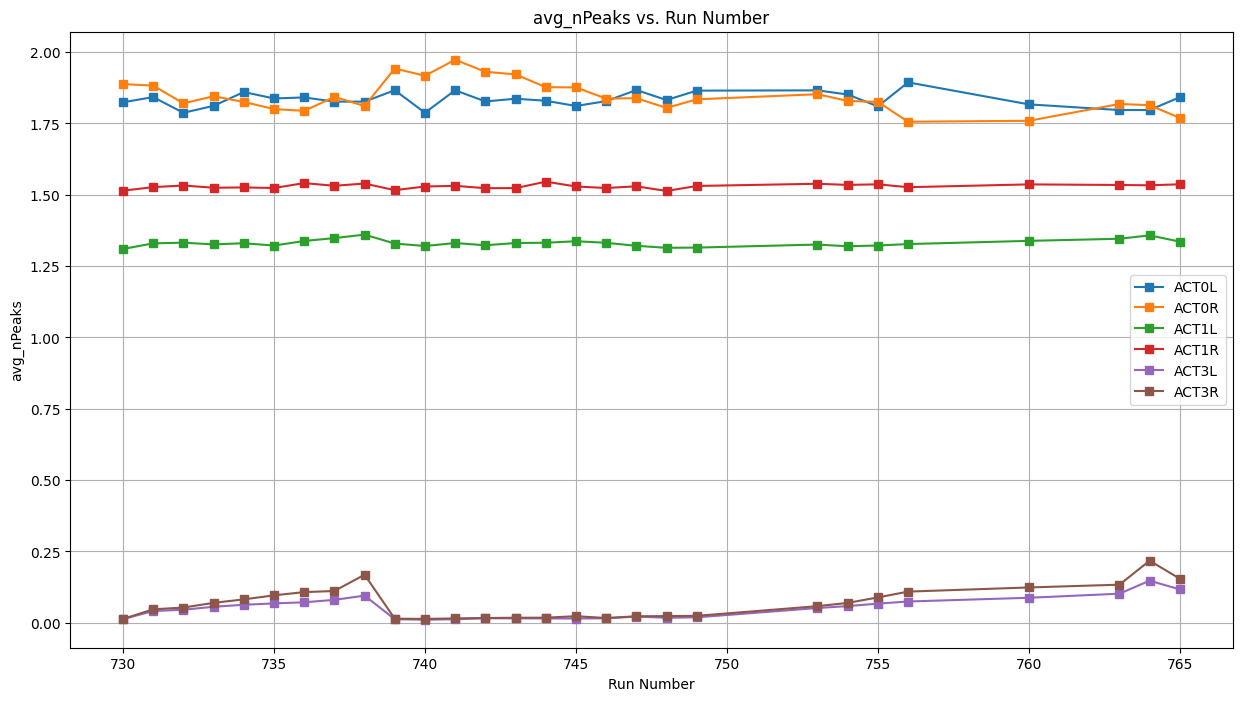

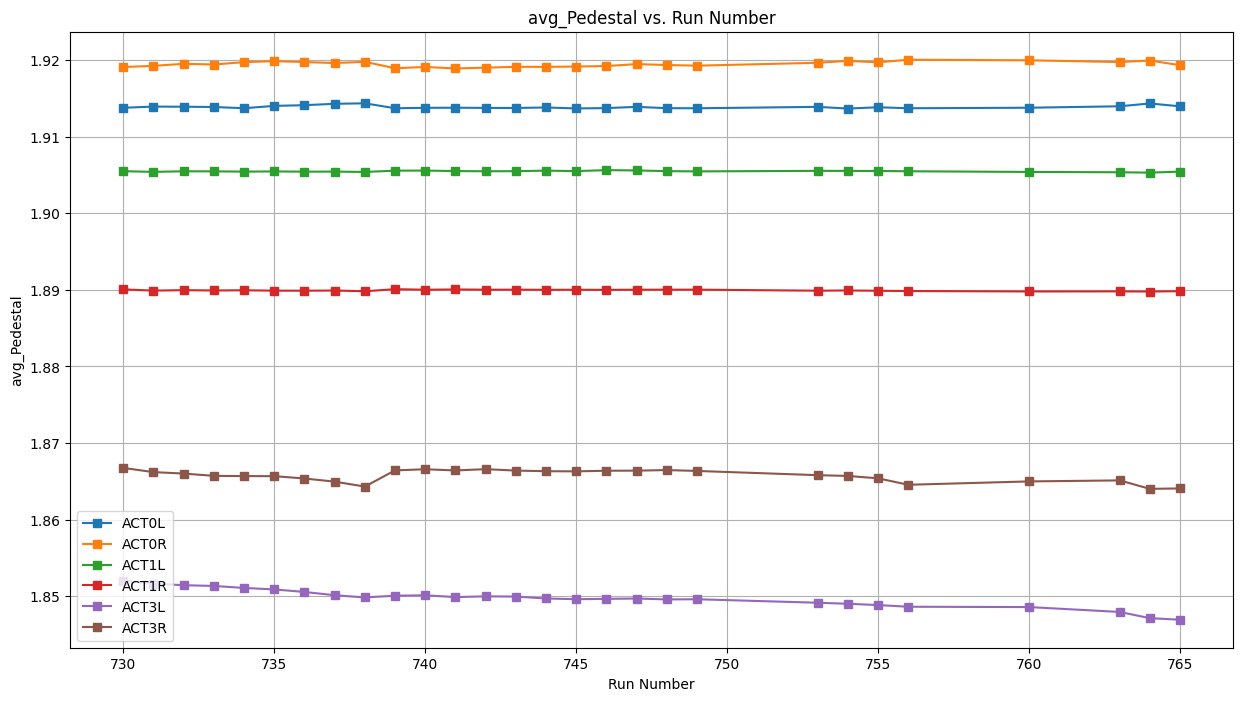

In [17]:
# For example, to plot avg_nPeaks for each detector element:
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R']
plot_statistics_vs_run(statistics_data, 'avg_nPeaks', act_set)
plot_statistics_vs_run(statistics_data, 'avg_Pedestal', act_set)

In [ ]:
df_dict = ntuple_to_pd_multipeak("../ntuples/ntuple_000734.root")

In [4]:
output_dir = "ntuples/run000734"

In [5]:
# Read in all dataframes from a given run
df_dict = read_dataframes_from_csv(output_dir)

In [6]:
df_dict['ACT0L'].head(10)

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge
0,0,0,2,1690841966,486764877,1.917449,0.012892,0.479000,159.0,150.564593,0.105608
1,0,1,2,1690841966,486764877,1.917449,0.012892,0.313089,181.0,176.314337,0.033916
2,1,0,2,1690841966,487879579,1.903706,0.059186,0.227347,163.0,158.406928,0.028177
3,1,1,2,1690841966,487879579,1.903706,0.059186,0.238916,177.0,172.123514,0.026385
4,2,0,2,1690841966,487949697,1.909270,0.022981,0.055162,79.0,72.567981,0.003926
5,2,1,2,1690841966,487949697,1.909270,0.022981,0.225011,159.0,154.039363,0.025535
6,3,0,1,1690841966,488659953,1.916350,0.015855,0.455486,155.0,147.663359,0.092167
7,4,0,2,1690841966,492016071,1.911126,0.015028,0.209239,151.0,145.240860,0.030625
8,4,1,2,1690841966,492016071,1.911126,0.015028,0.193185,183.0,179.028012,0.022729
9,5,-1,0,1690841966,492095121,1.910318,0.016252,-1.000000,-1.0,-1.000000,-1.000000


In [7]:
df_dict.keys()

dict_keys(['HD0', 'HD13', 'ACT0L', 'EventInfo', 'PbGlass', 'HD10', 'TOF13', 'TOF12', 'HD14', 'TOF02', 'TriggerScint', 'ACT3R', 'HD3', 'TOF01', 'ACT0R', 'HD1', 'TOF00', 'HD6', 'HD9', 'HD4', 'ACT1R', 'HD5', 'HD12', 'TOF10', 'ACT3L', 'TOF11', 'HD11', 'HD7', 'HD2', 'HD8', 'TOF03', 'ACT1L'])

In [18]:
def plot_histograms_for_each_signal(df_dict, base_dir=".", rnum = 0, quantity='nPeaks', select_nonzero_peaks=False, logscale=False):
    # Define the custom order for the keys
    custom_order = [
        'ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R',
        'TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13',
        'TriggerScint',
        'PbGlass',
        'HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14'
    ]
    
    out_dir = f"{base_dir}/{rnum}"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Create a grid of 8 rows x 4 columns
    fig, axes = plt.subplots(8, 4, figsize=(16, 24))
    flat_axes = axes.ravel()

    # Iterate based on the custom order
    for key, ax in zip(custom_order, flat_axes):
        df = df_dict[key]
        
        # Select only non-zero peaks if specified.
        if(select_nonzero_peaks):
            df_select = df[df['nPeaks'] > 0]
        else:
            df_select = df

        # Plot histogram for the current signal on its corresponding axis
        n, bins, patches = ax.hist(df_select[quantity], bins=20, edgecolor='black', alpha=0.7, label=key)  # capture output to use in legend
        #ax.set_title(key)
        ax.set_xlabel(quantity)
        ax.set_ylabel('Counts/bin')
        ax.legend()  # Add legend
        
        if(logscale):
            ax.set_yscale('log')

    # Adjust the layout so the plots do not overlap
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"{out_dir}/{quantity}.pdf", bbox_inches='tight')

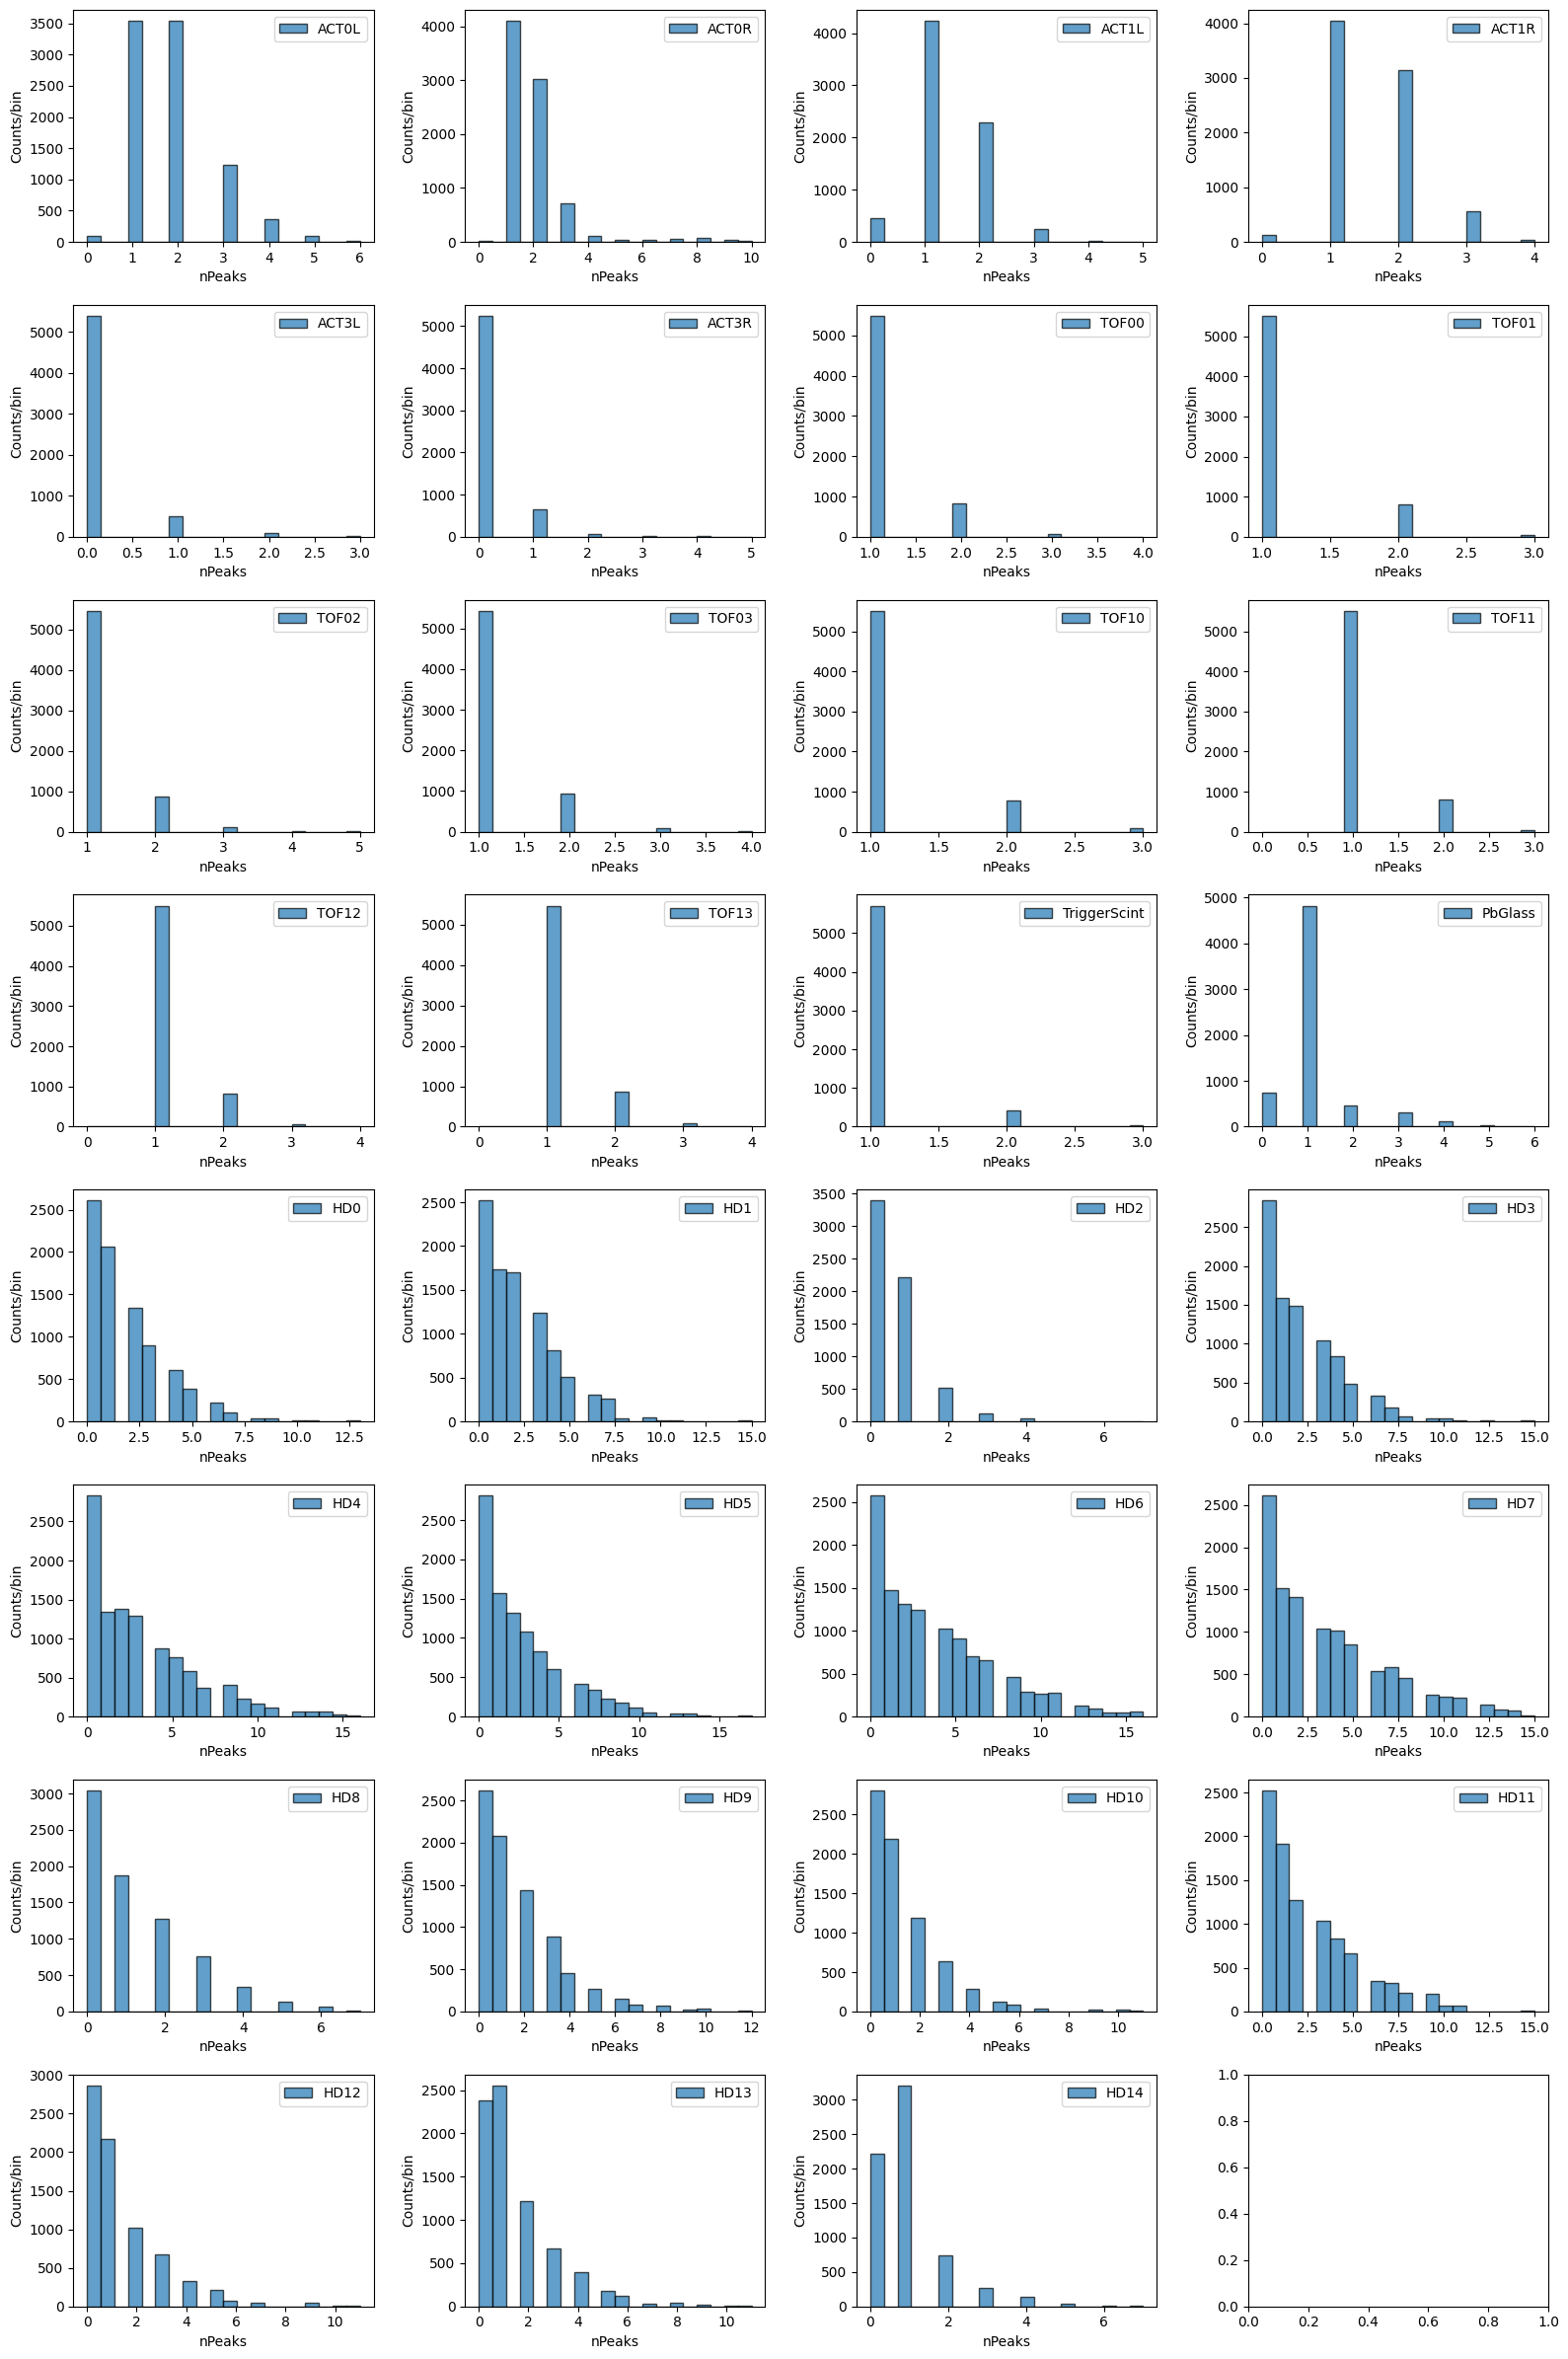

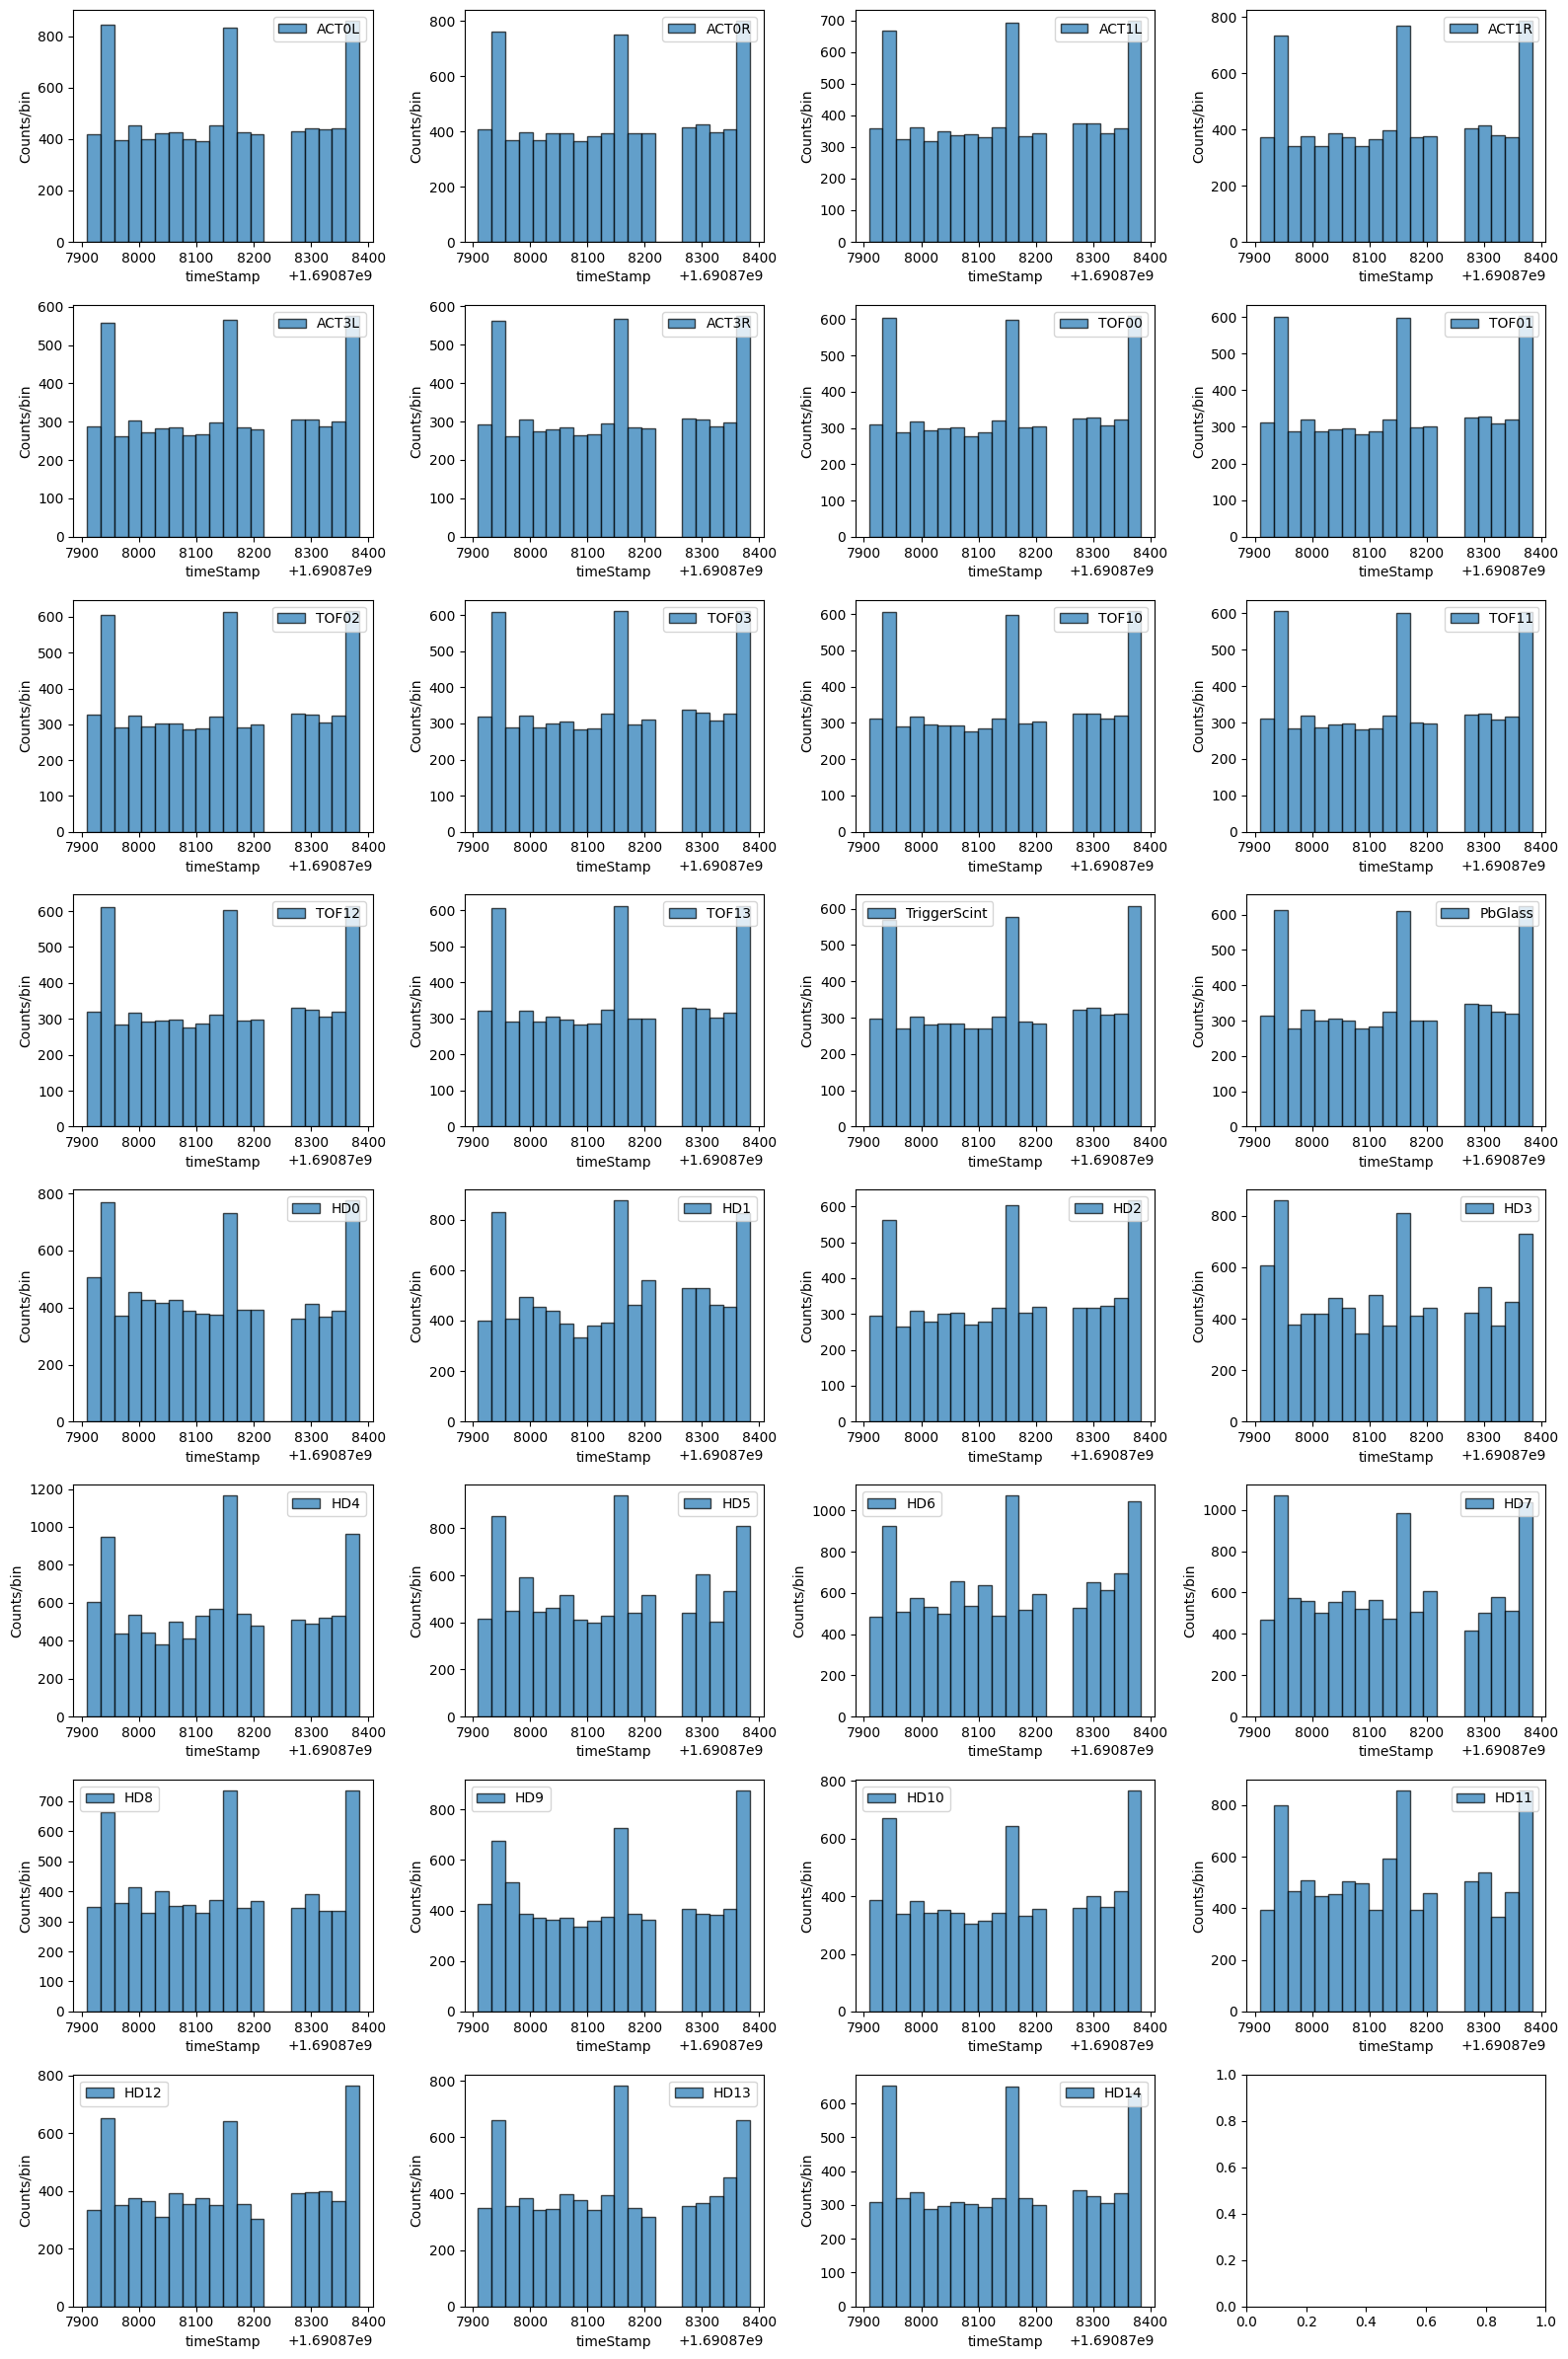

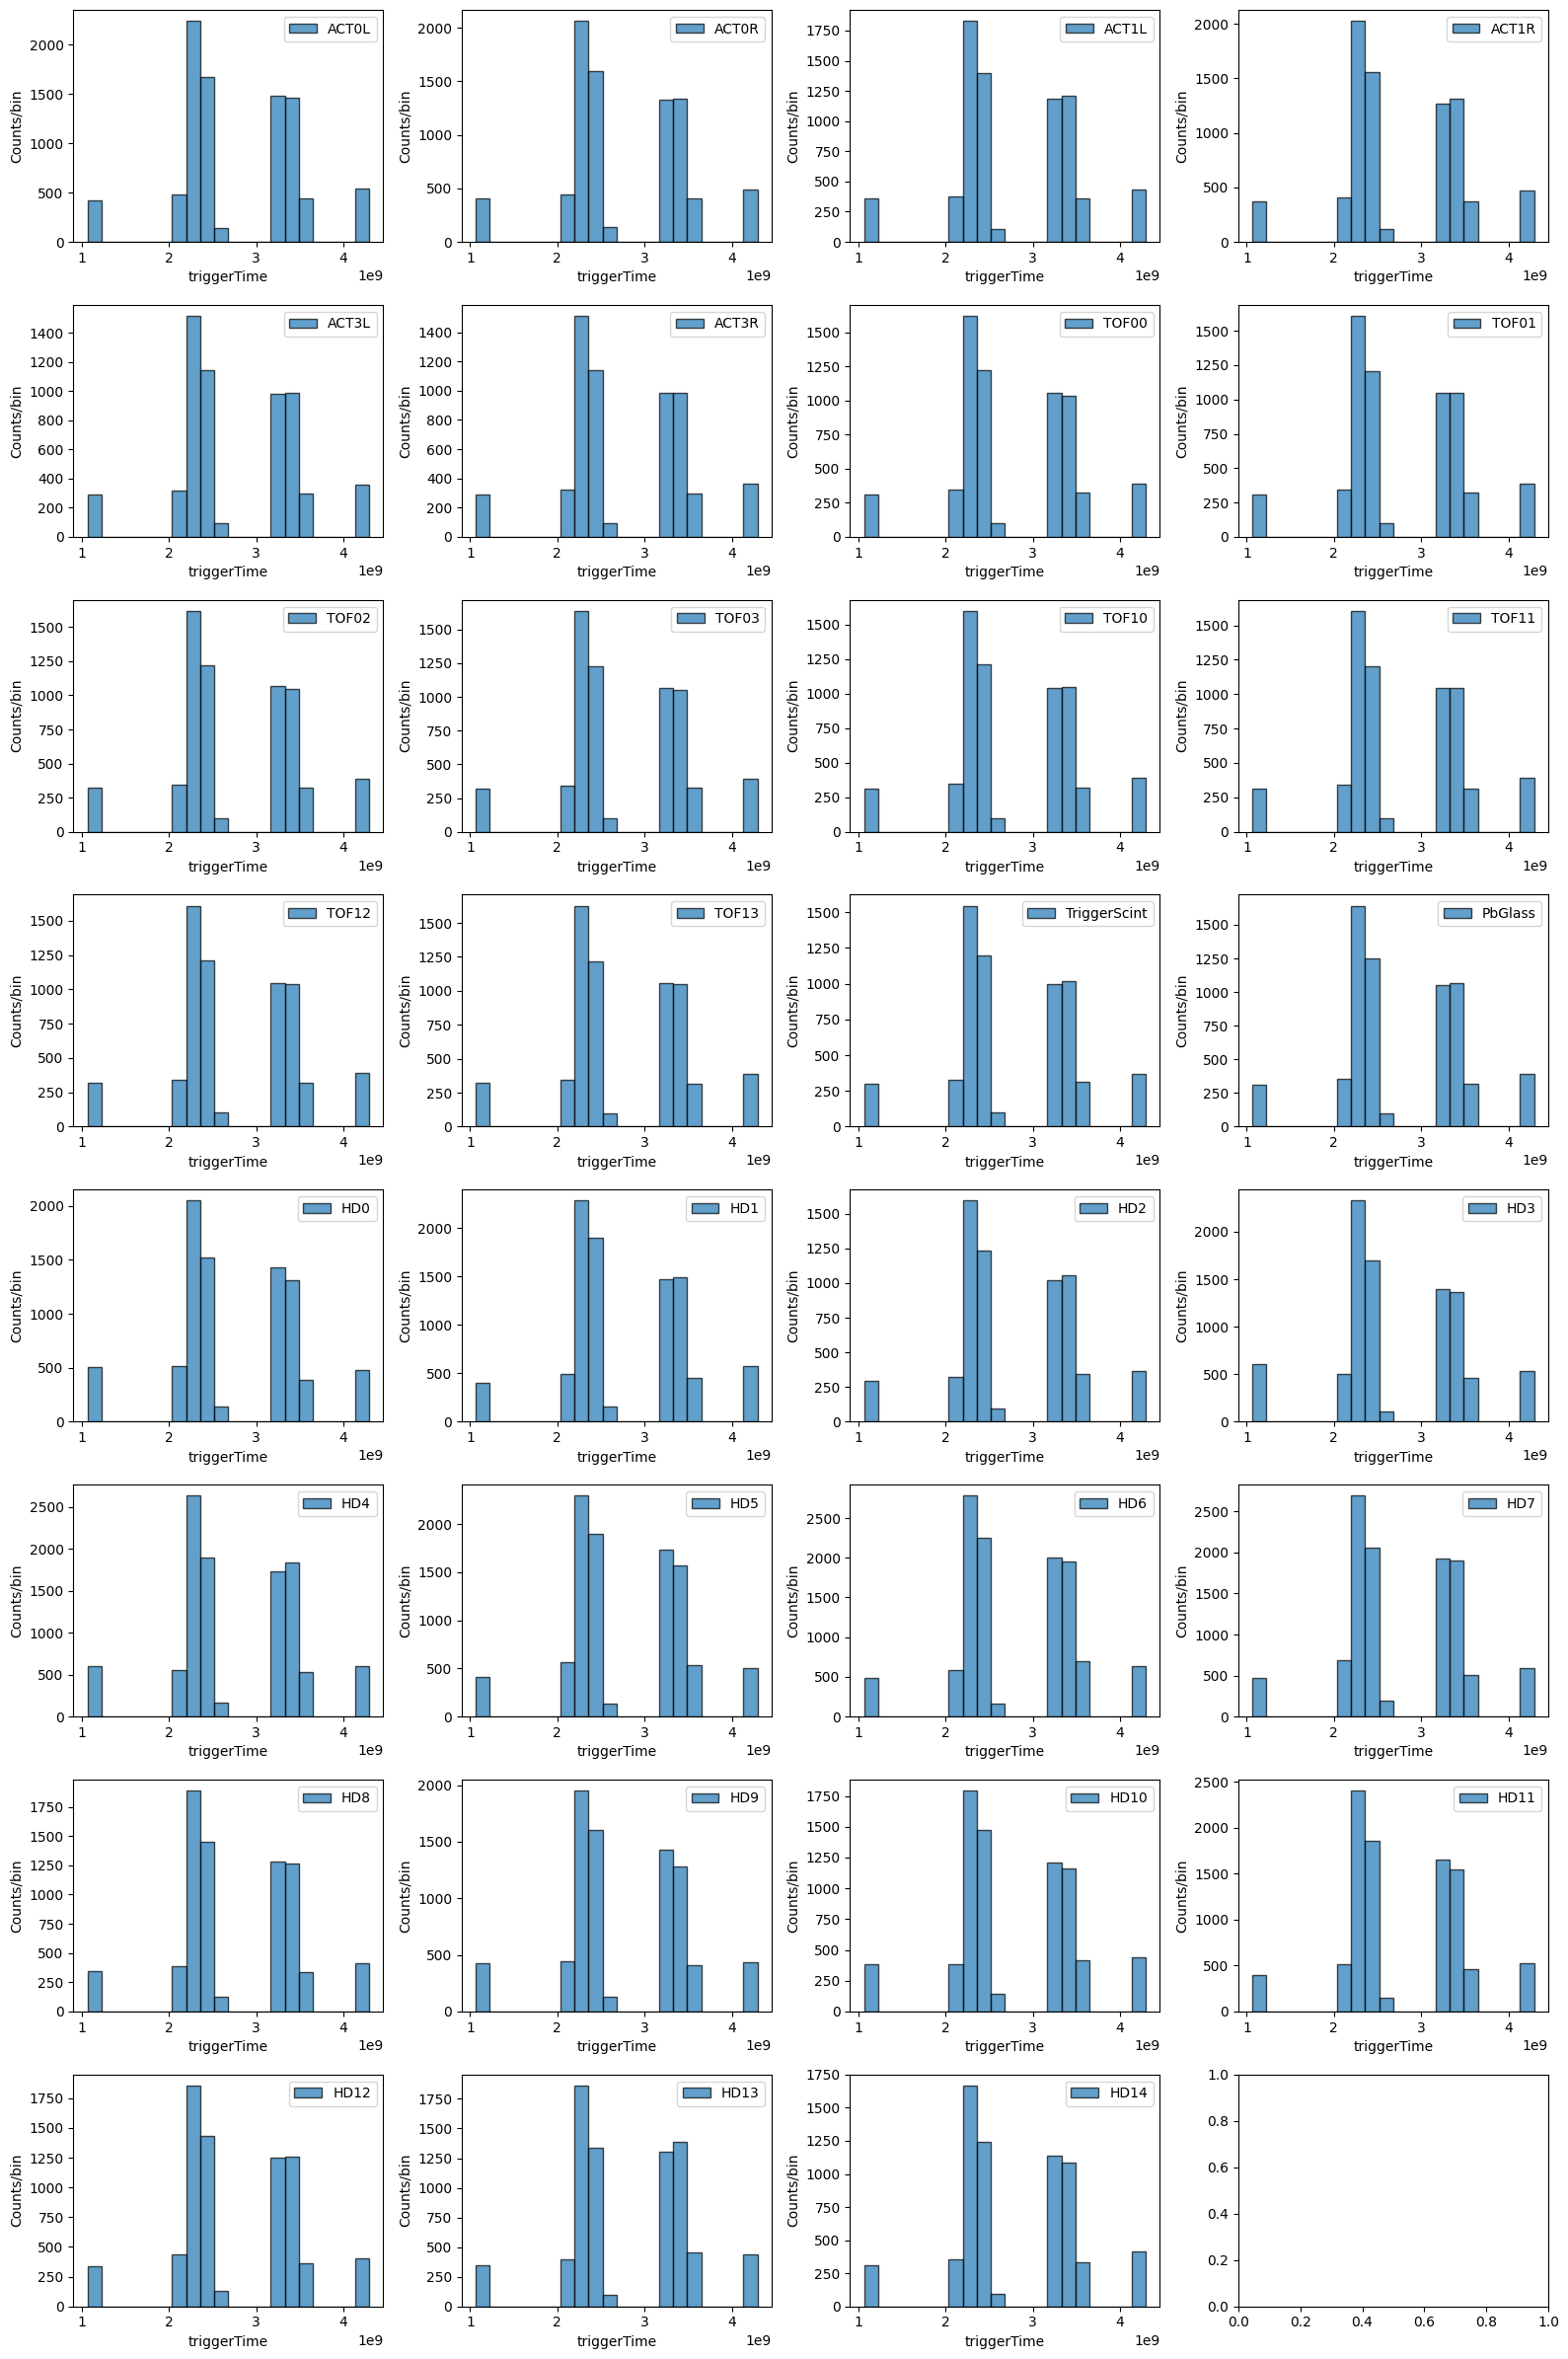

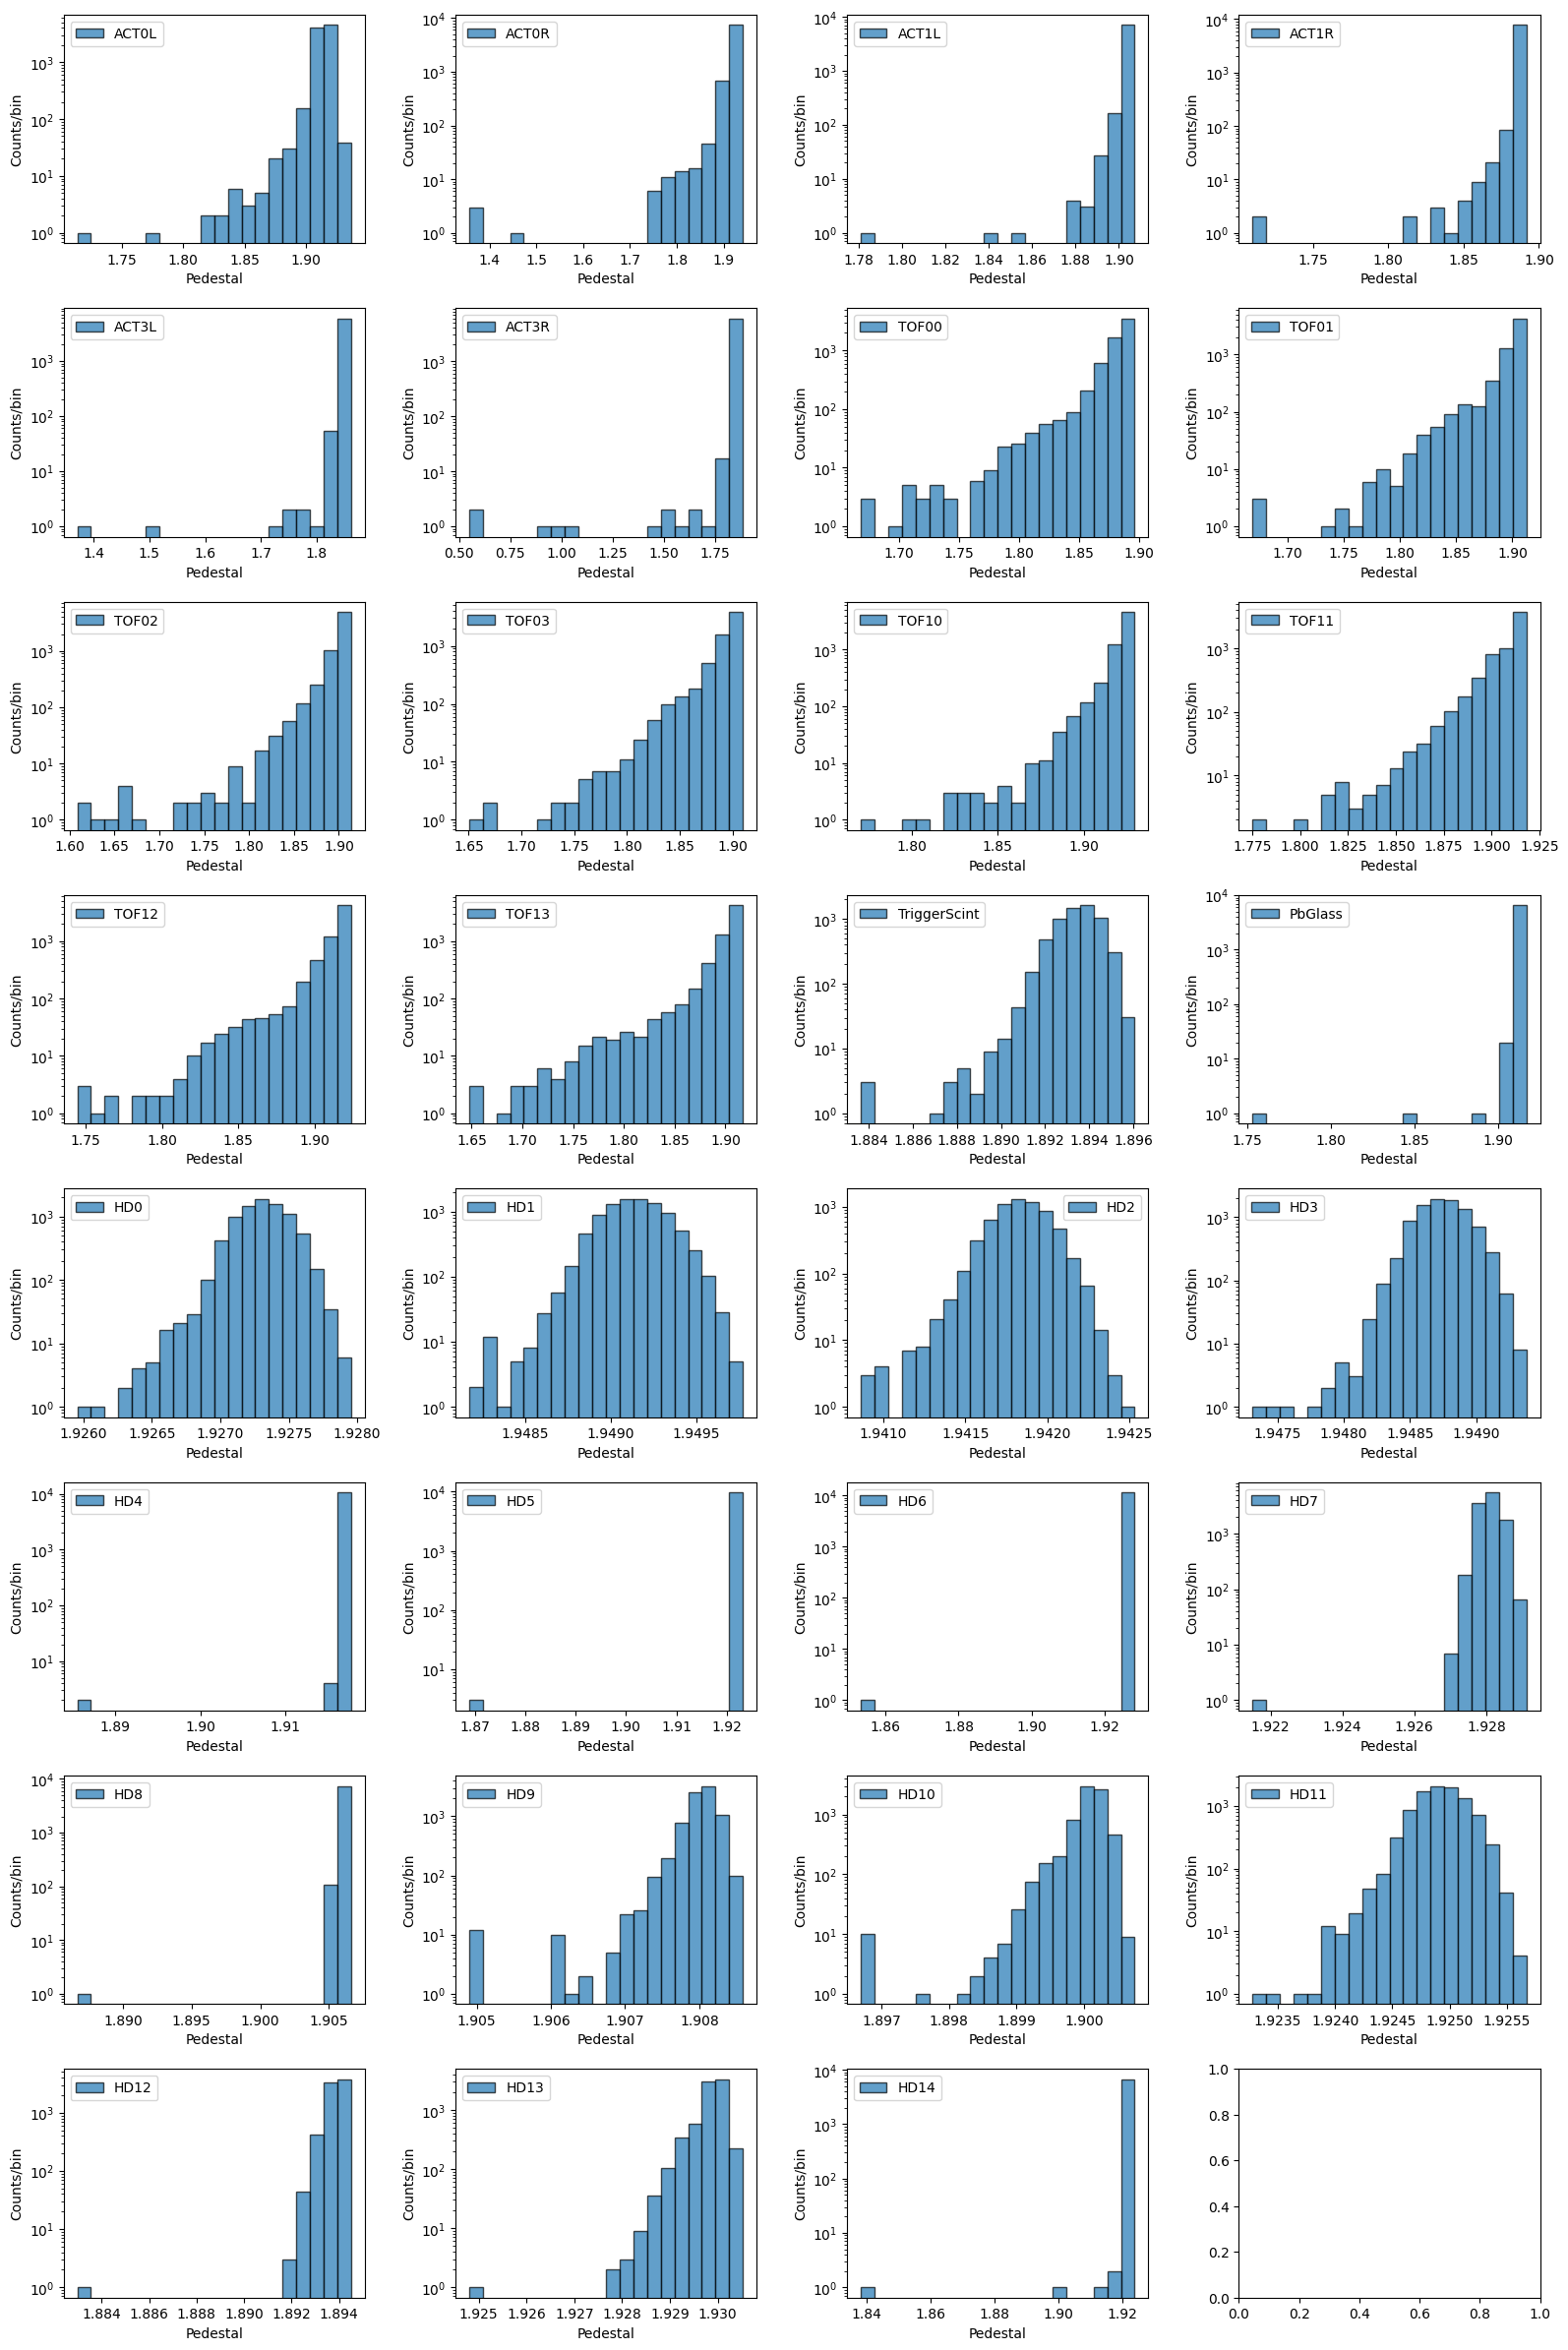

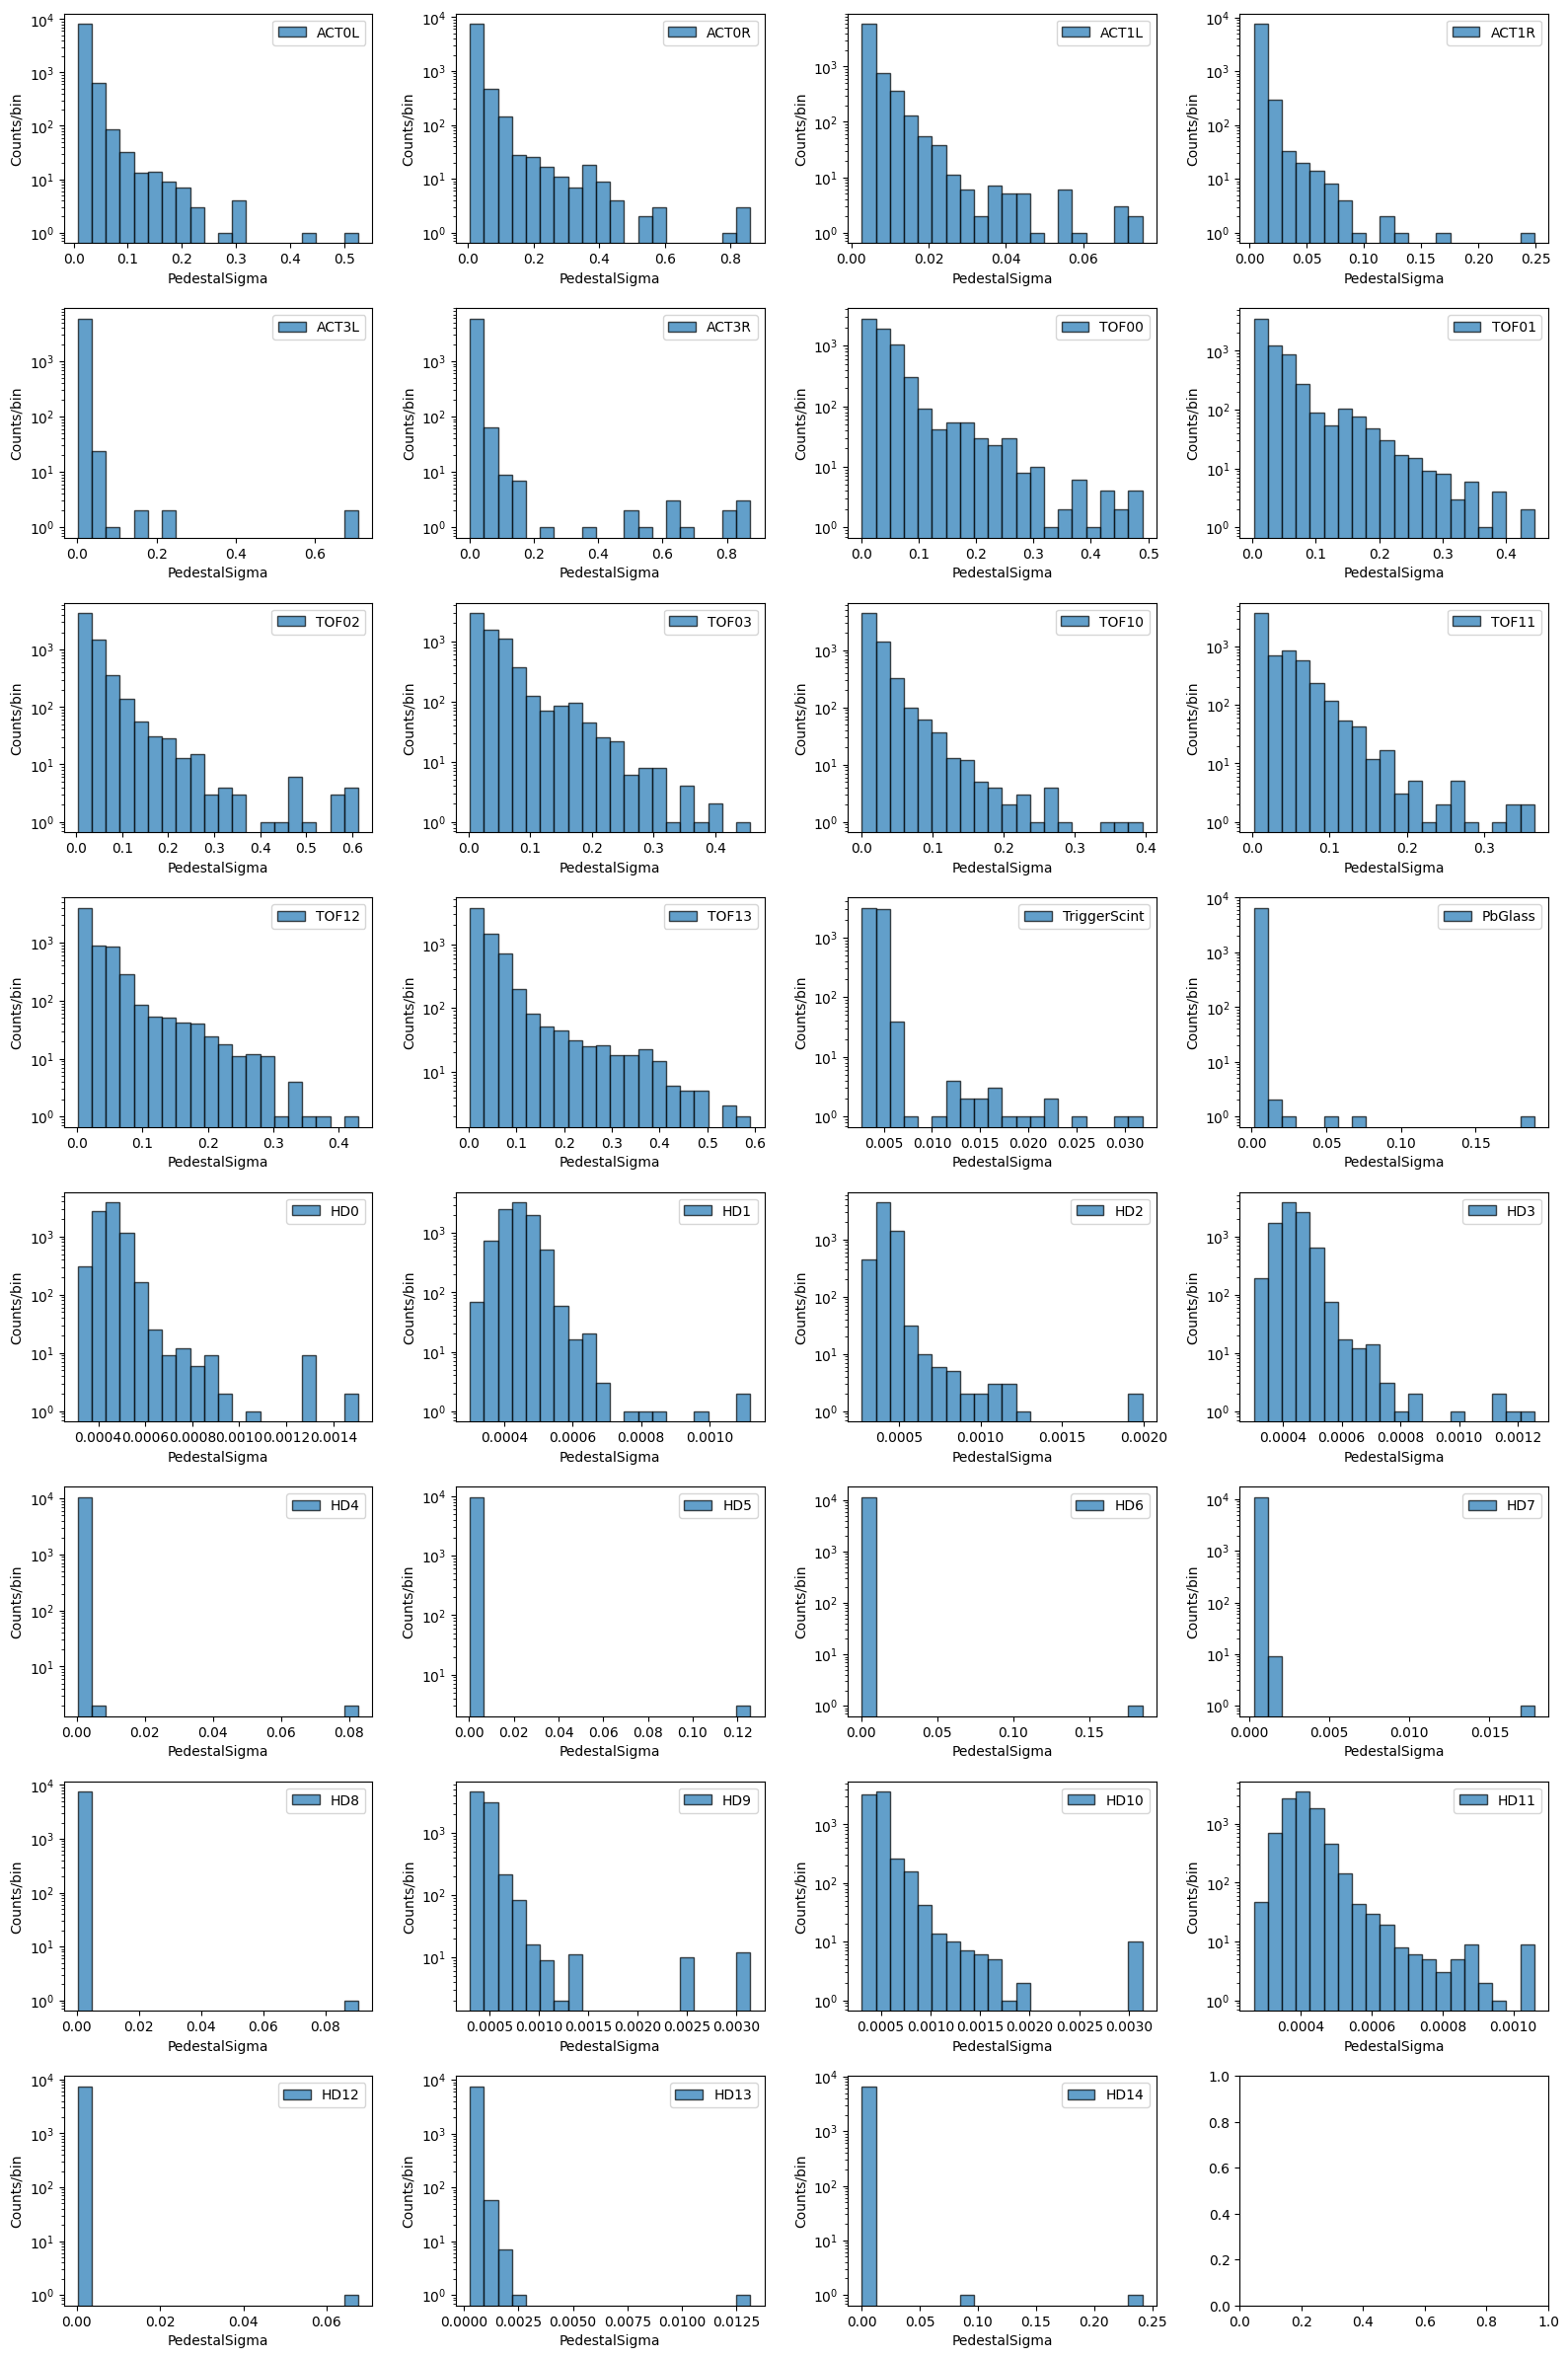

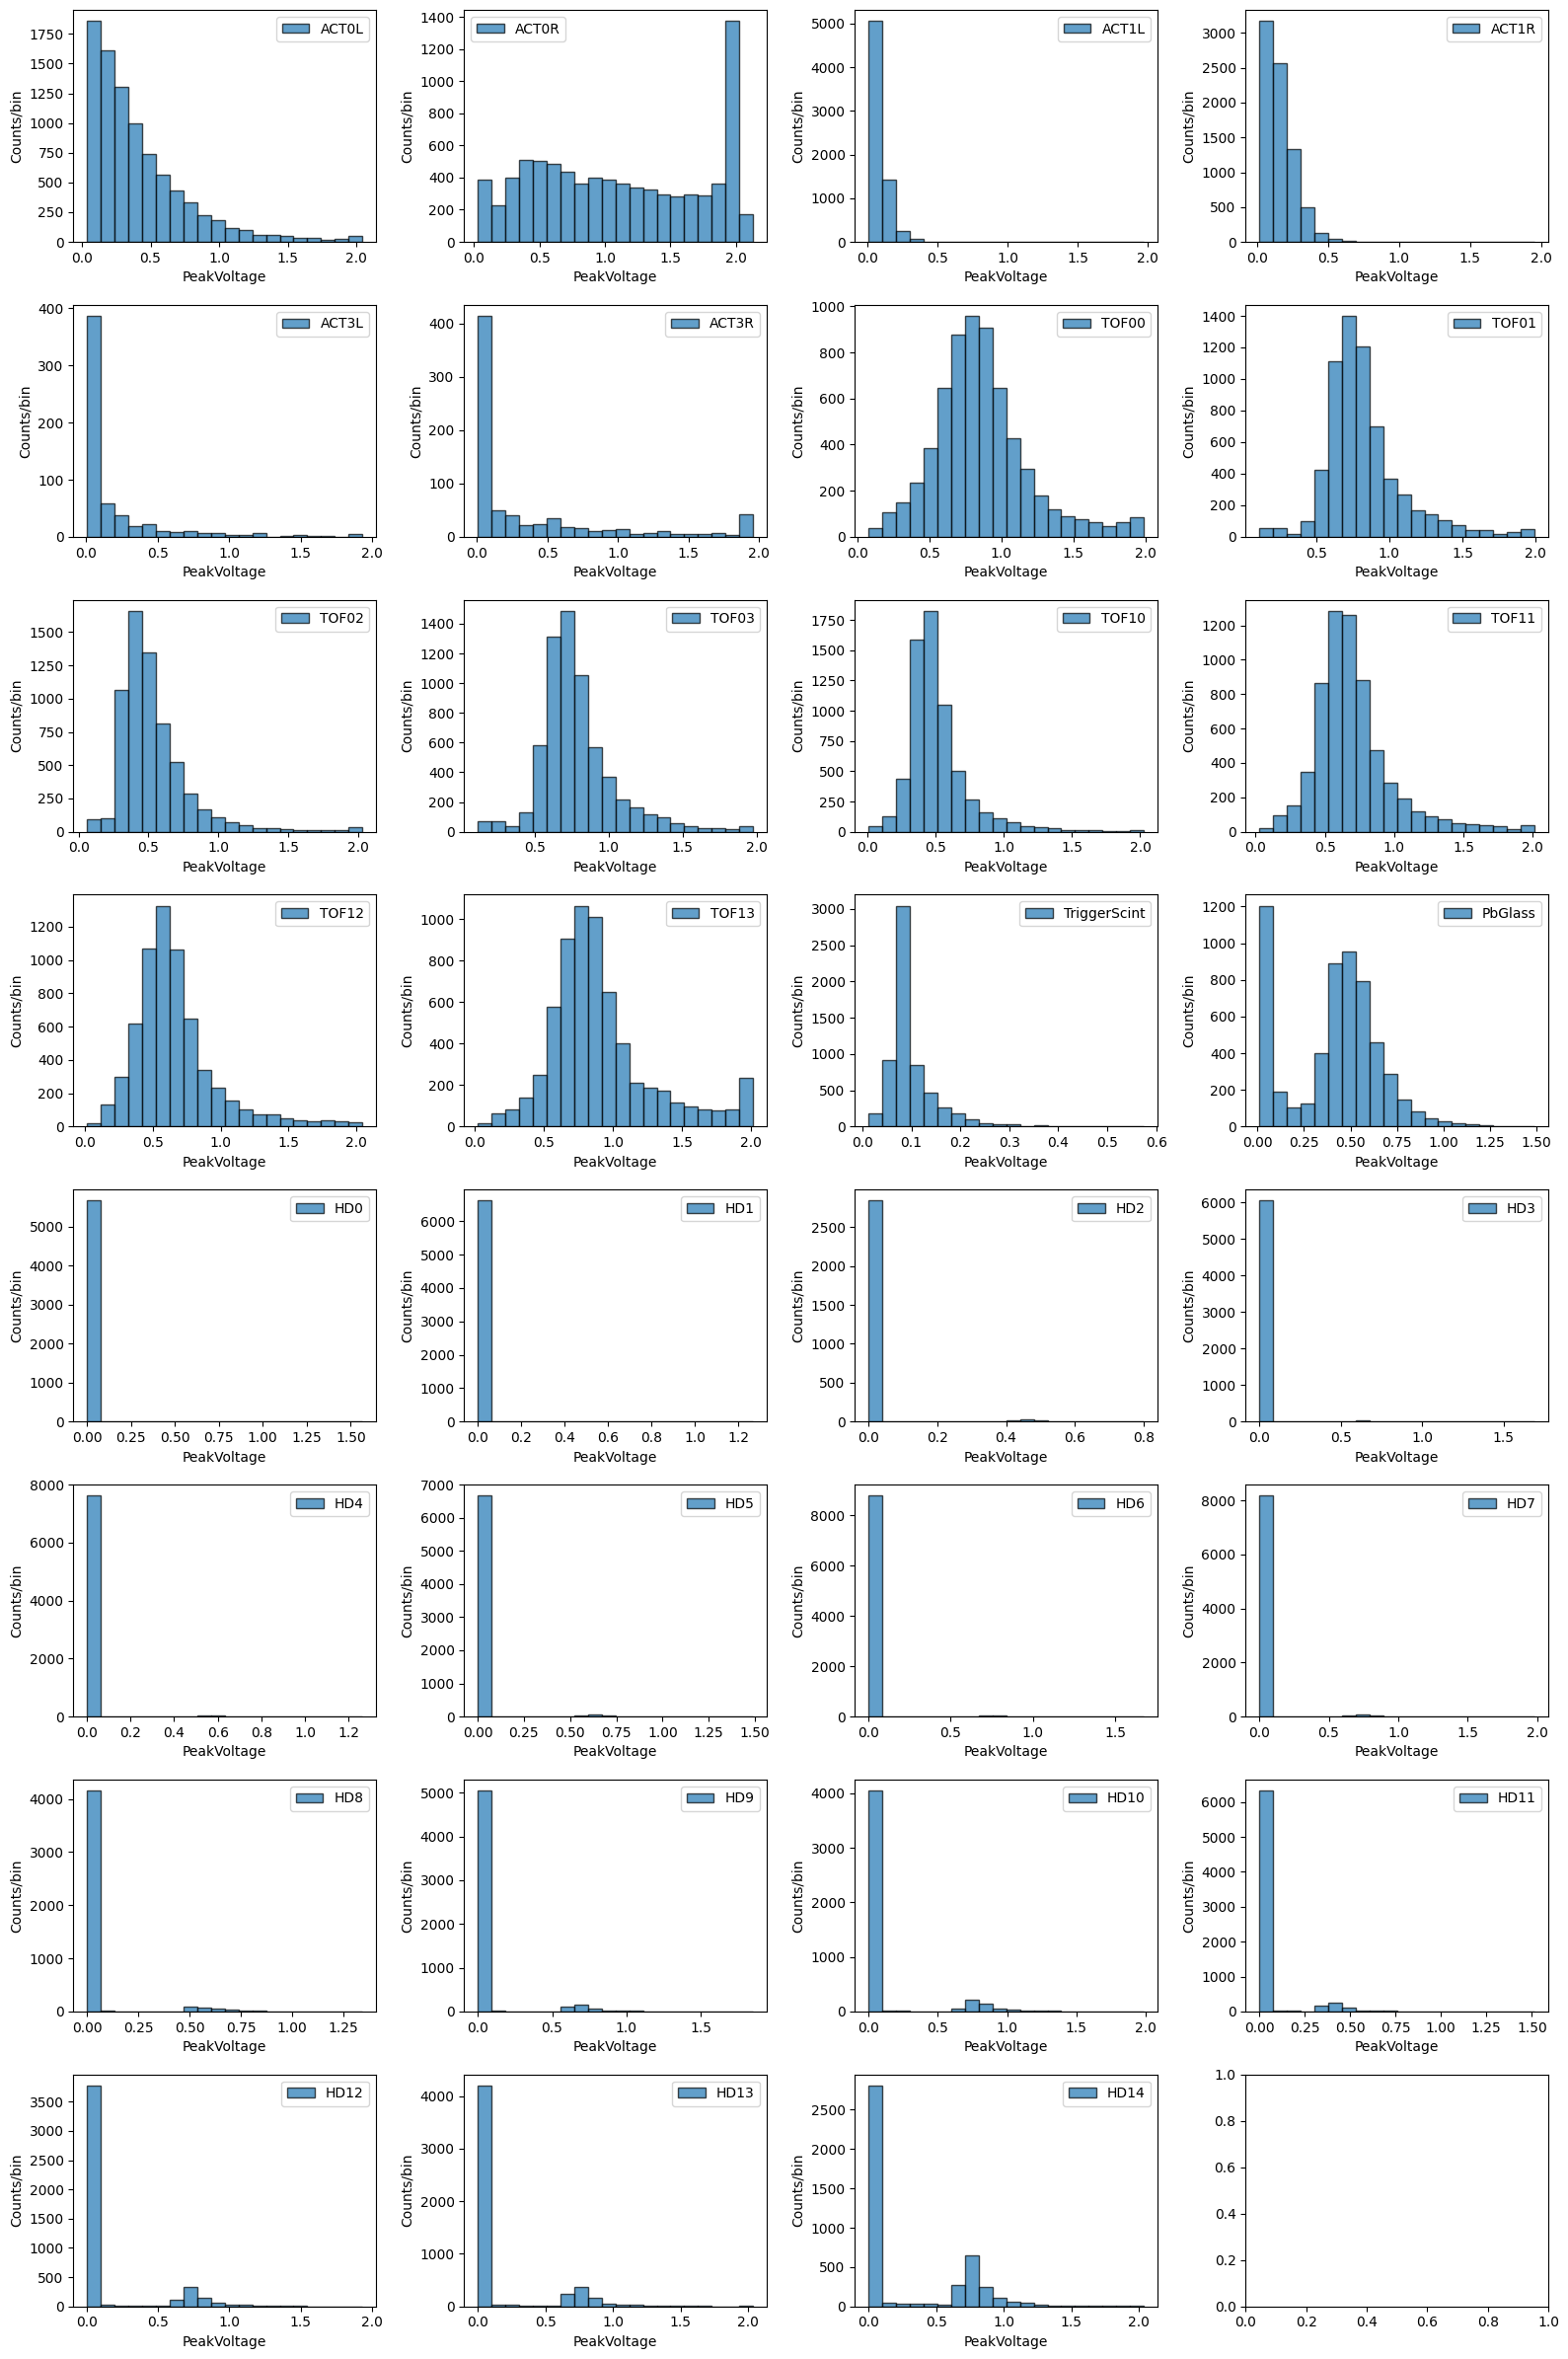

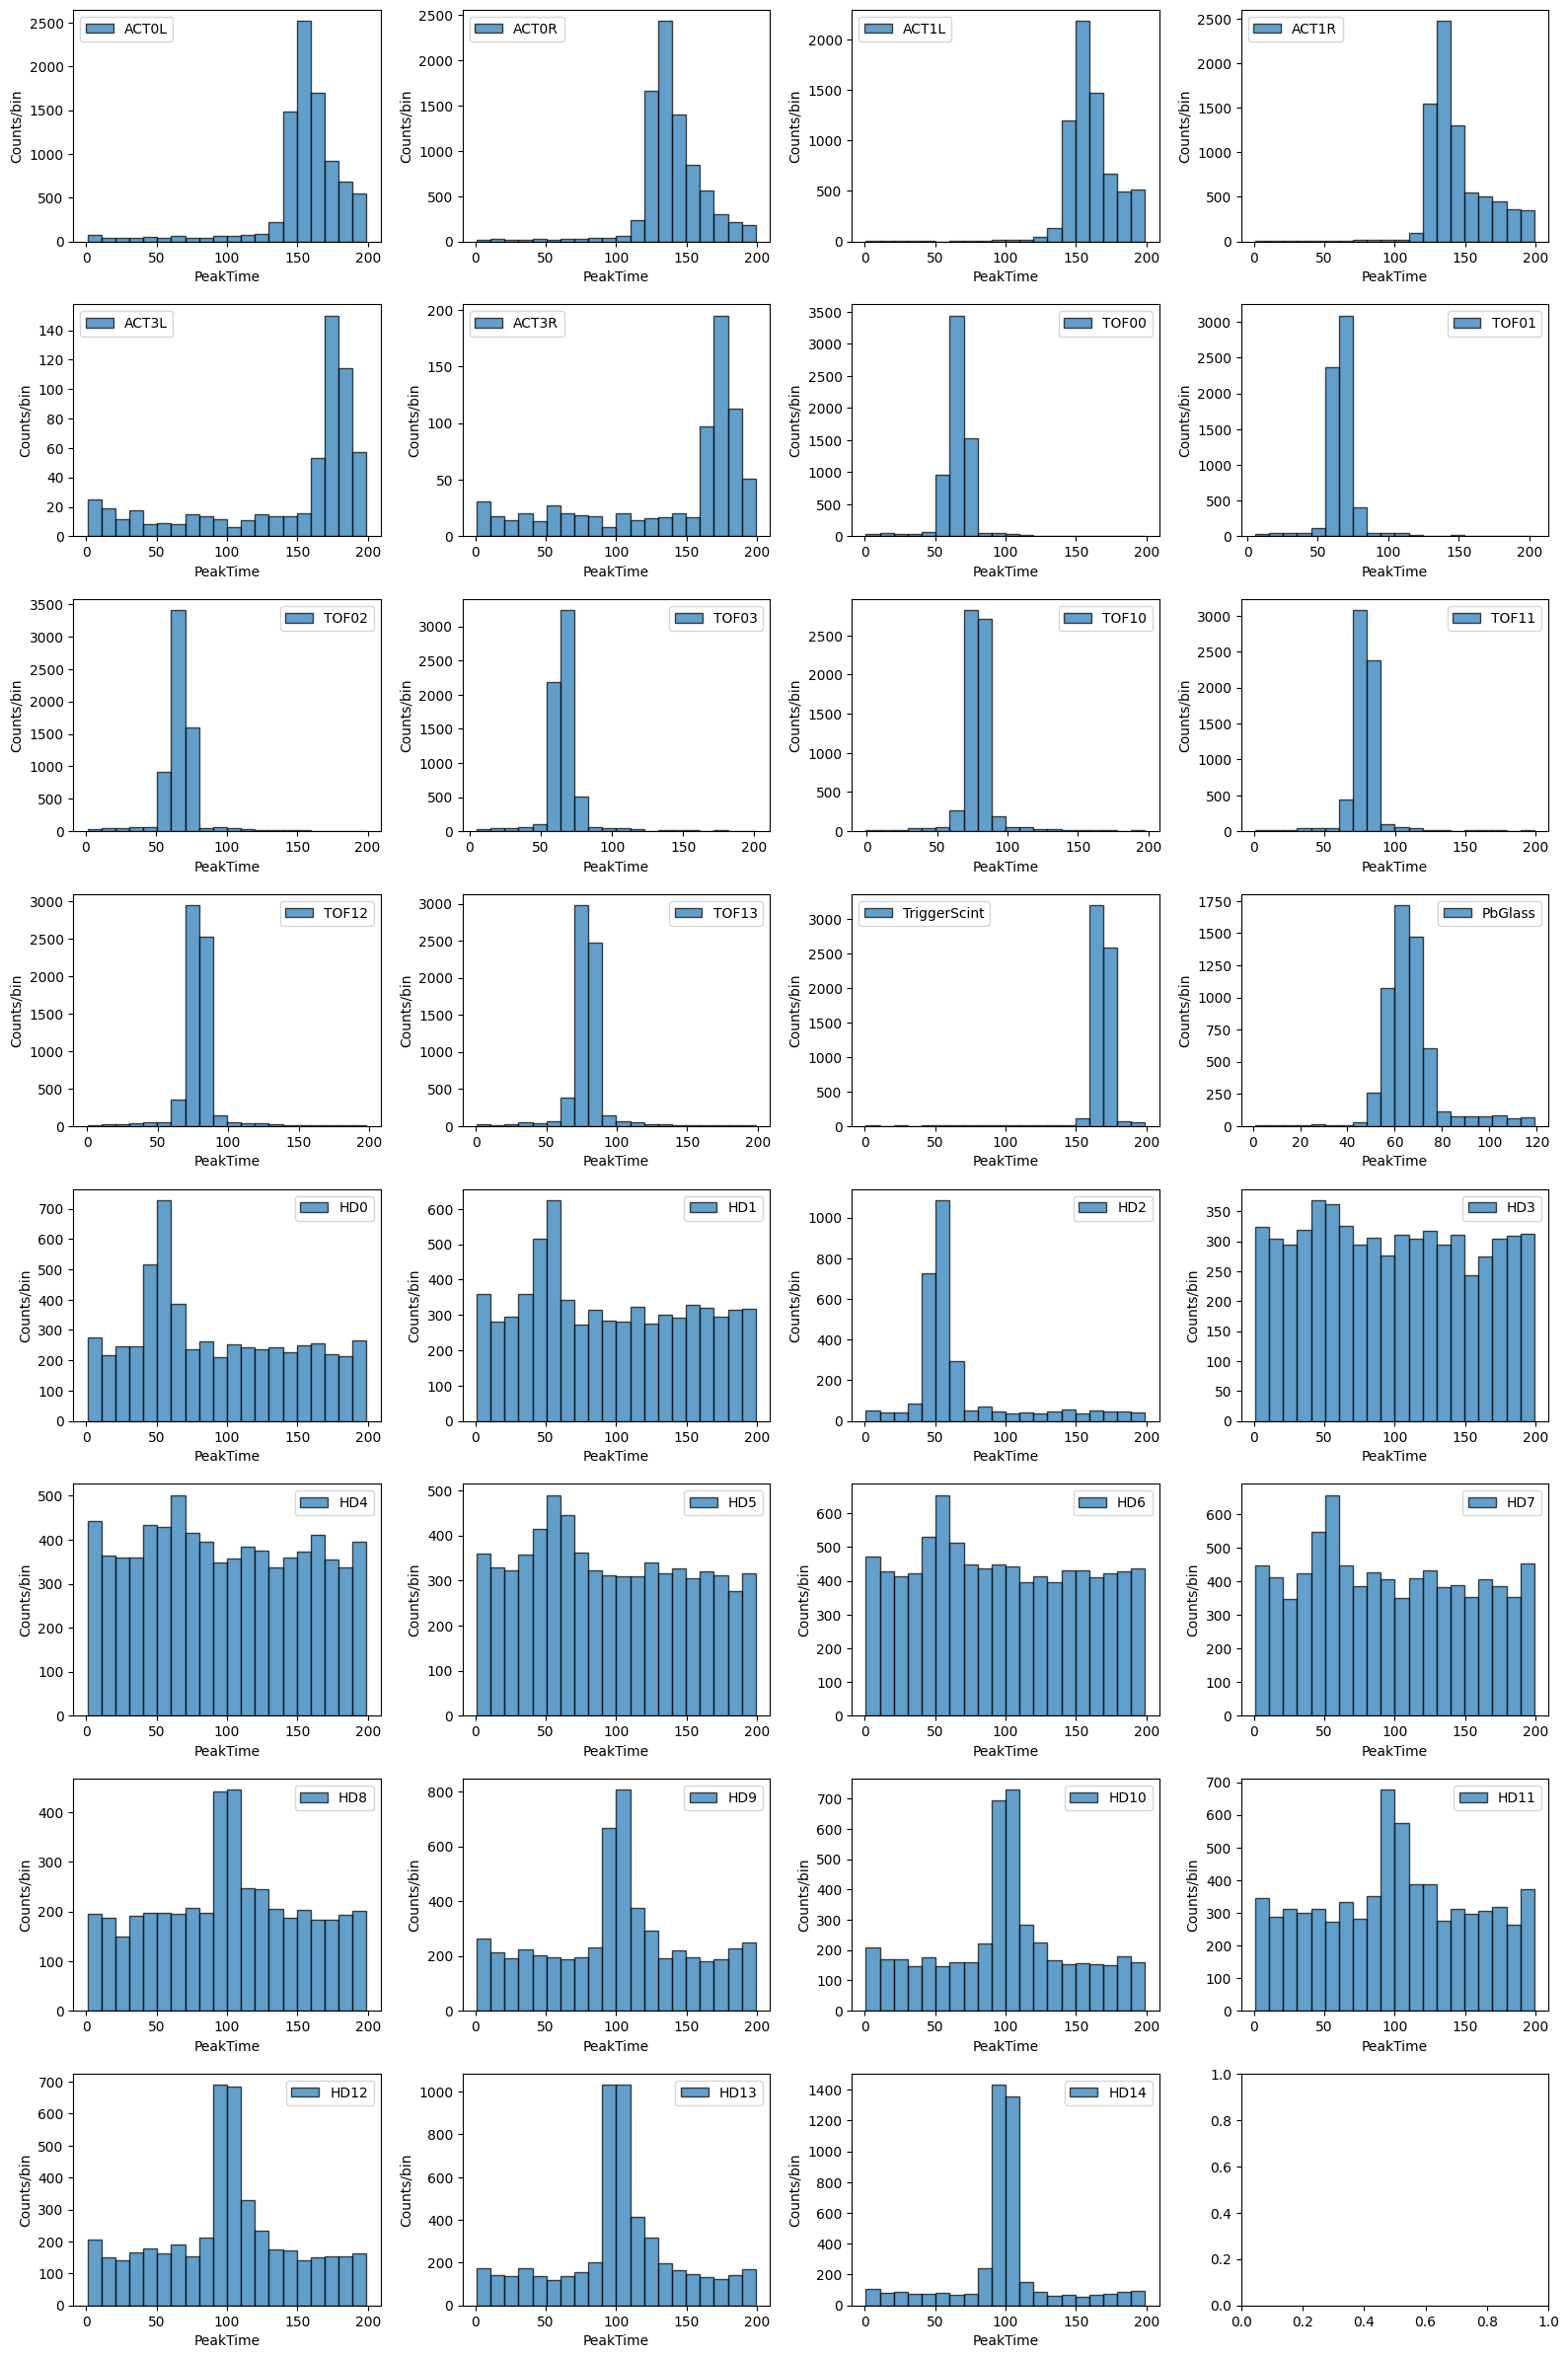

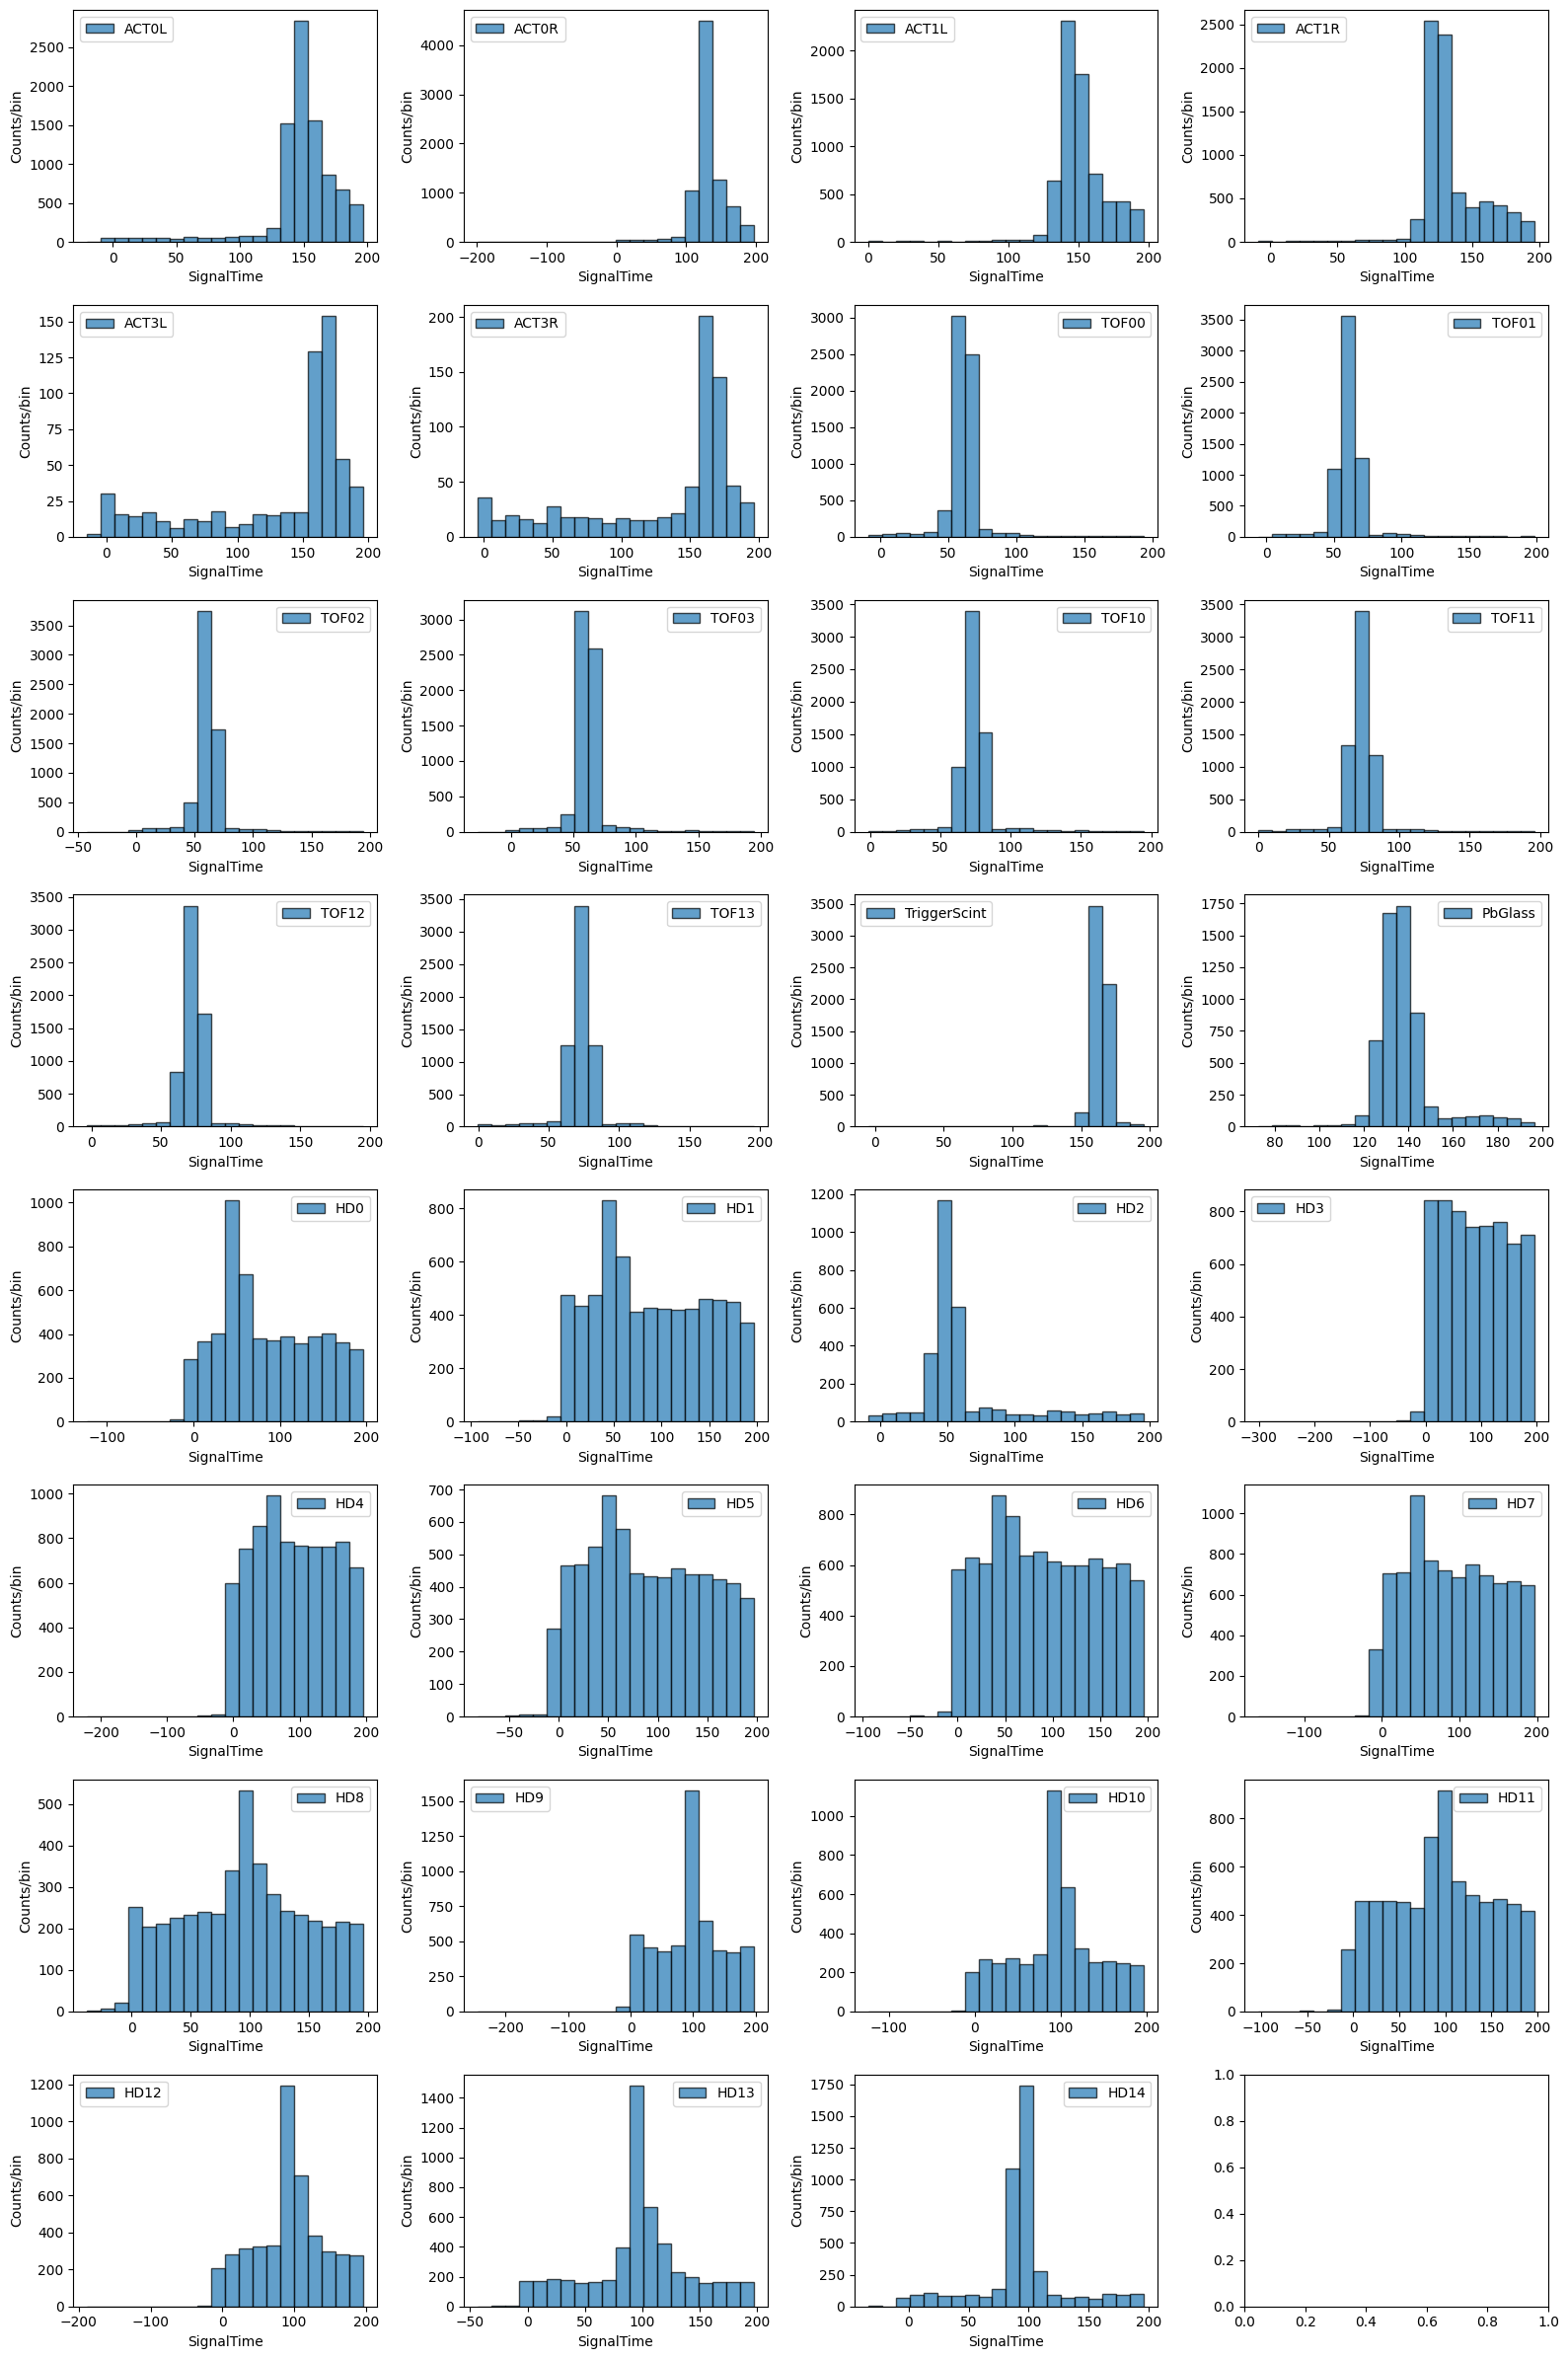

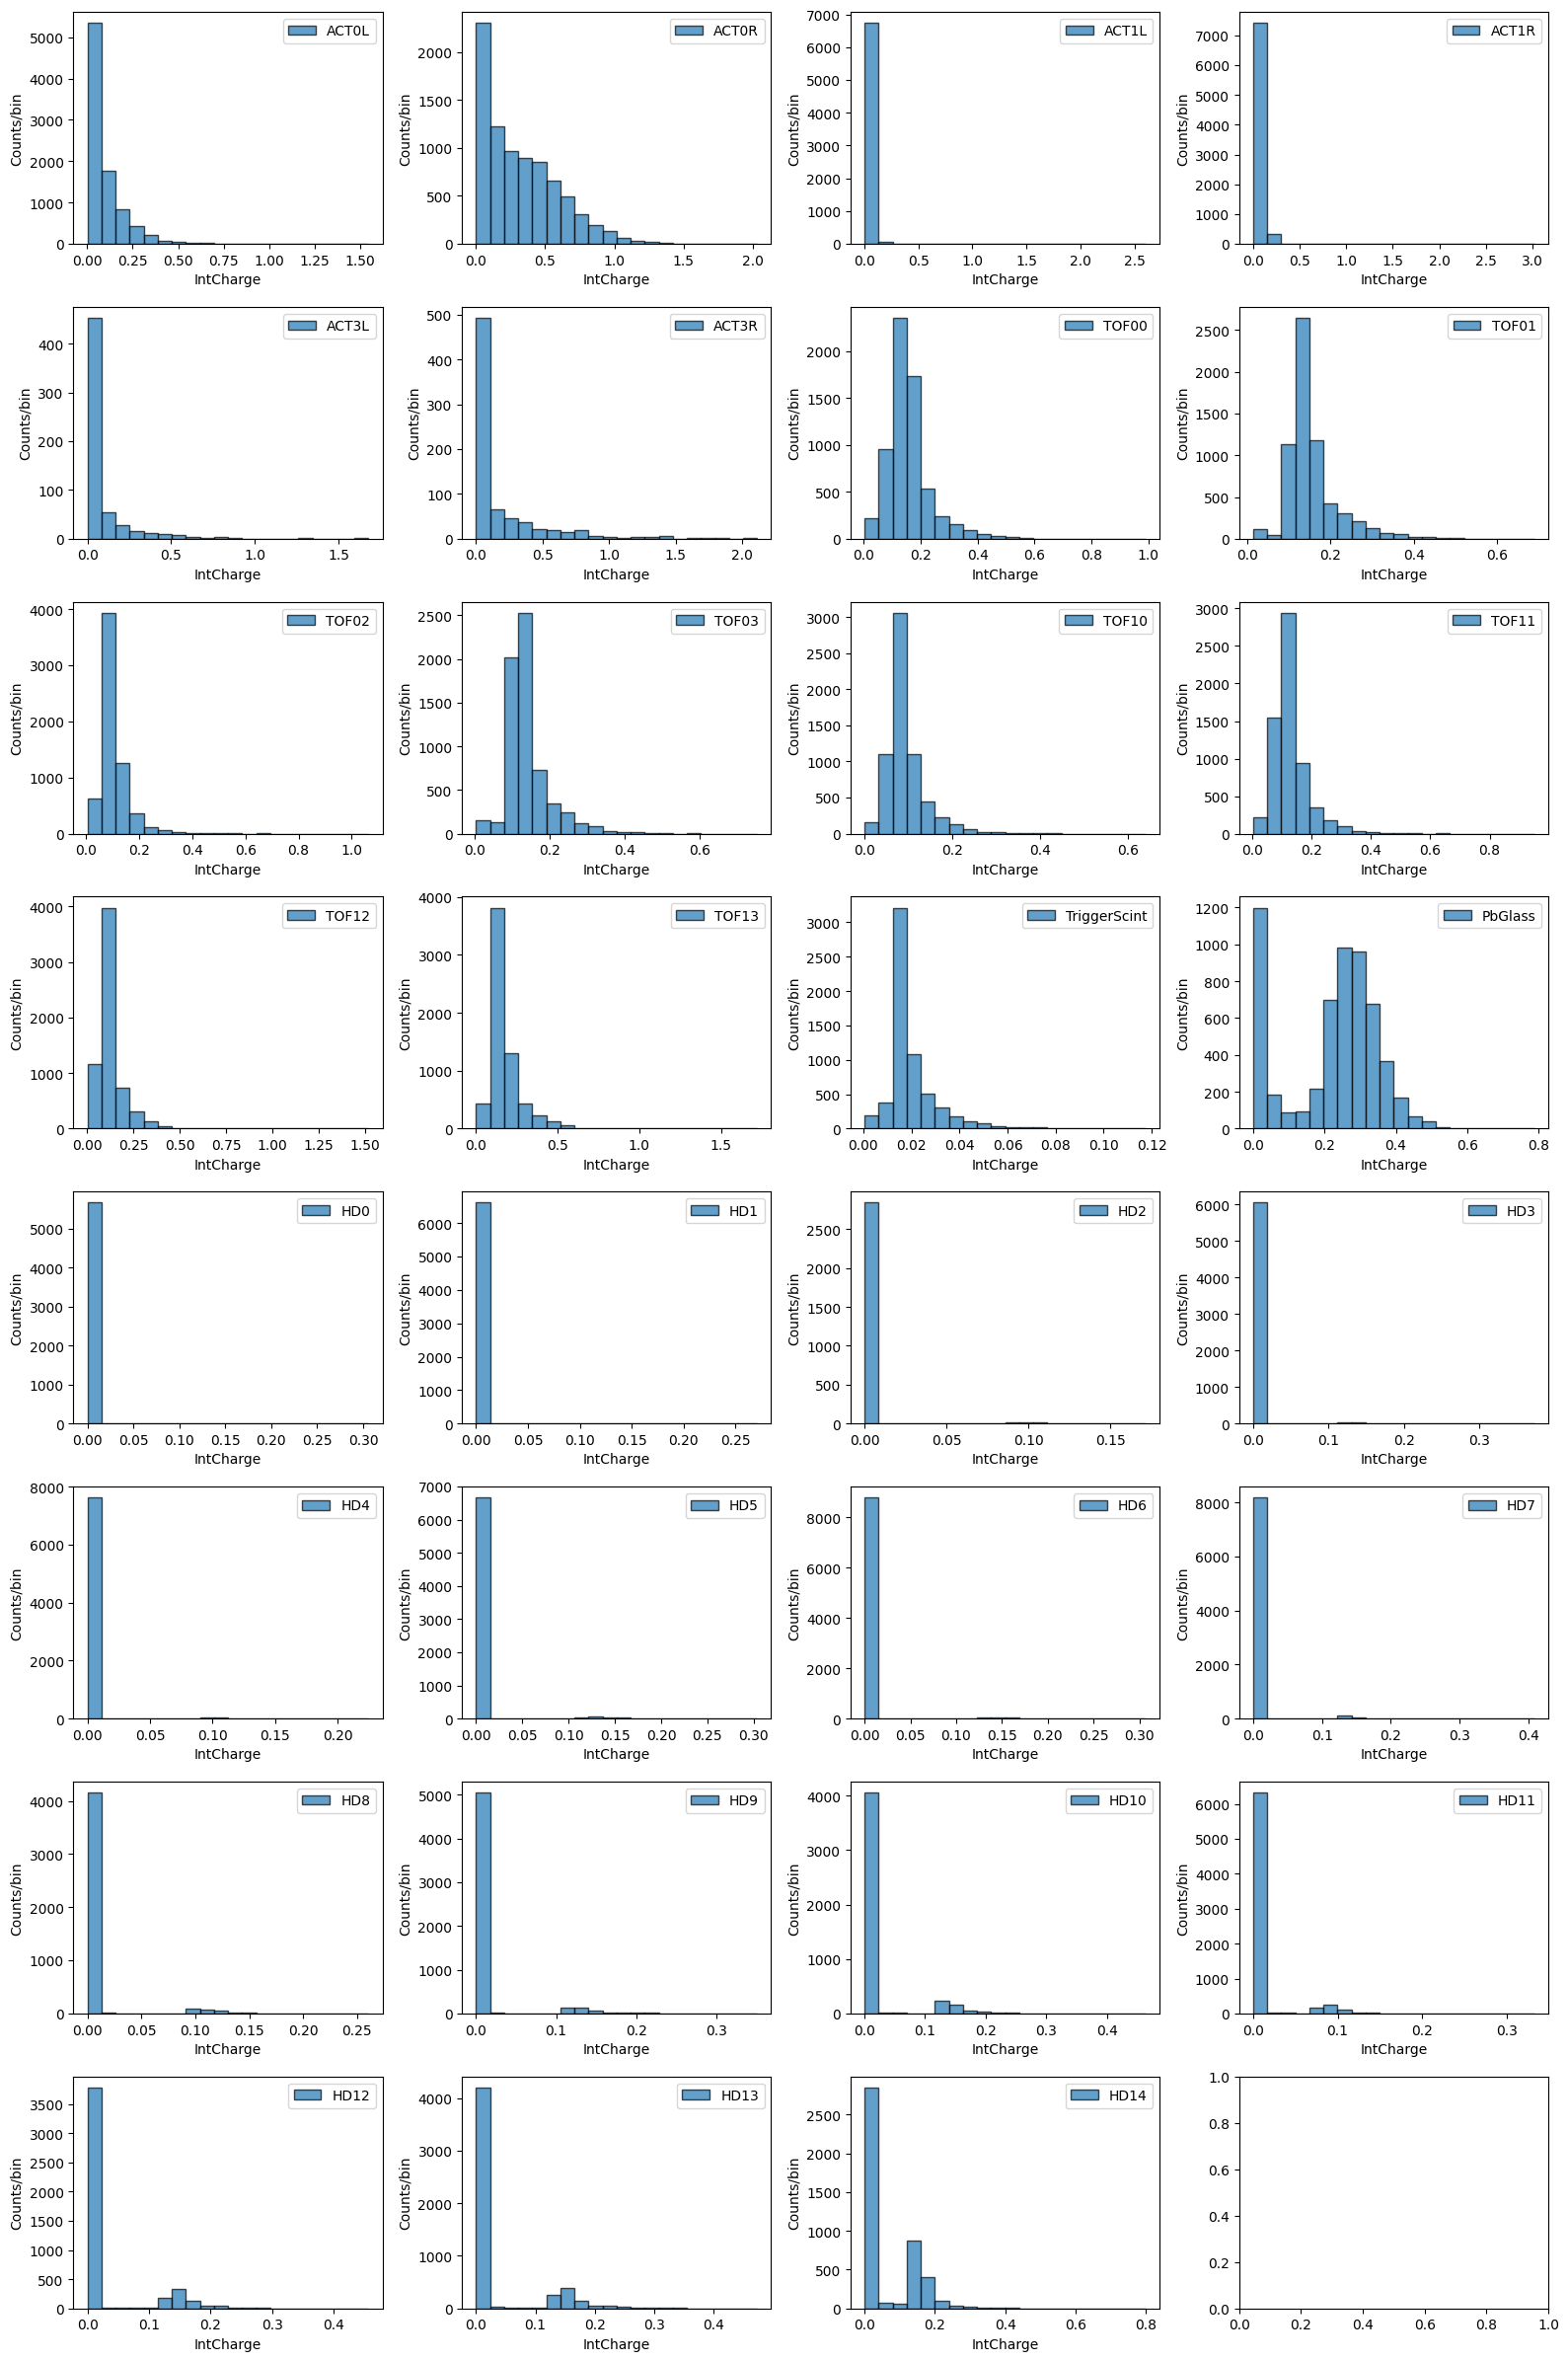

In [19]:
# Test the function
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='nPeaks', select_nonzero_peaks=False, logscale=False)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='timeStamp', select_nonzero_peaks=False, logscale=False)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='triggerTime', select_nonzero_peaks=False, logscale=False)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='Pedestal', select_nonzero_peaks=False, logscale=True)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='PeakTime', select_nonzero_peaks=True, logscale=False)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='SignalTime', select_nonzero_peaks=True, logscale=False)
plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum='000734', quantity='IntCharge', select_nonzero_peaks=True, logscale=False)

In [ ]:
events = uproot.open("{}".format("../ntuples/ntuple_000734.root"))
main_keys = events.keys()

In [ ]:
dataframes

## Single-peak analysis

### Runs 670 - 677: Trigger T0 and T2 Coincidence with Hodoscope OR Lead Glass - 1% Slit
#### Please note that ntuples 672 (700 MeV), 674 (900 MeV), 675 (1 GeV) and 716 (700 MeV) cannot be produced with Nick script. This is something that may need to be considered.

In [ ]:
# Convert the ROOT file to a CSV
run  = "000734"
path = "../ntuples/ntuple_"
df   = ntuple_to_pd(path + "{}.root".format(run))

In [ ]:
df.head(100)

## Peak time analysis

In [ ]:
# Create entries in dataframe for averages in peak times
df['PeakTimeACT0'] = (df['PeakTime0'] + df['PeakTime1'])/2
df['PeakTimeACT1'] = (df['PeakTime2'] + df['PeakTime3'])/2
df['PeakTimeACT3'] = (df['PeakTime4'] + df['PeakTime5'])/2
df['PeakVoltageACT3'] = (df['PeakVoltage4'] + df['PeakVoltage5'])/2
df['PeakTimeTOF0'] = (df['PeakTime8'] + df['PeakTime9'] + df['PeakTime10'] + df['PeakTime11'])/4
df['PeakTimeTOF1'] = (df['PeakTime12'] + df['PeakTime13'] + df['PeakTime14'] + df['PeakTime15'])/4

In [ ]:
rng_time = [0,200]
nbins_time = 100

fig = plt.figure(figsize=(18,7))

h_ACT0R = plt.hist(df['PeakTime0'],bins=nbins_time,range=rng_time,label="ACT0-R")
h_ACT0L = plt.hist(df['PeakTime1'],bins=nbins_time,range=rng_time,label="ACT0-L")
h_ACT1L = plt.hist(df['PeakTime2'],bins=nbins_time,range=rng_time,label="ACT1-R")
h_ACT1R = plt.hist(df['PeakTime3'],bins=nbins_time,range=rng_time,label="ACT1-L")
h_ACT3L = plt.hist(df['PeakTime4'],bins=nbins_time,range=rng_time,label="ACT3-R")
h_ACT3R = plt.hist(df['PeakTime5'],bins=nbins_time,range=rng_time,label="ACT3-L")

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="Trigger scintillator")

h_TOF00 = plt.hist(df['PeakTime8'],bins=nbins_time,range=rng_time,label='TOF0-0')
h_TOF01 = plt.hist(df['PeakTime9'],bins=nbins_time,range=rng_time,label='TOF0-1')
h_TOF02 = plt.hist(df['PeakTime10'],bins=nbins_time,range=rng_time,label='TOF0-2')
h_TOF03 = plt.hist(df['PeakTime11'],bins=nbins_time,range=rng_time,label='TOF0-3')

h_TOF10 = plt.hist(df['PeakTime12'],bins=nbins_time,range=rng_time,label='TOF1-0')
h_TOF11 = plt.hist(df['PeakTime13'],bins=nbins_time,range=rng_time,label='TOF1-1')
h_TOF12 = plt.hist(df['PeakTime14'],bins=nbins_time,range=rng_time,label='TOF1-2')
h_TOF13 = plt.hist(df['PeakTime15'],bins=nbins_time,range=rng_time,label='TOF1-3')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=14)
plt.savefig("peak_times.png", bbox_inches='tight')

In [ ]:
rng_time = [0,200]
nbins_time = 60
alpha_time = 0.8

fig = plt.figure(figsize=(18,7))

h_ACT0 = plt.hist(df['PeakTimeACT0'],bins=nbins_time,range=rng_time,label="ACT0 avg",alpha=alpha_time)
h_ACT1 = plt.hist(df['PeakTimeACT1'],bins=nbins_time,range=rng_time,label="ACT1 avg",alpha=alpha_time)
h_ACT3 = plt.hist(df[df['PeakVoltageACT3'] > 0.5]['PeakTimeACT3'],bins=nbins_time,range=rng_time,label="ACT3 avg (V$_{peak}$ > 0.5)",alpha=alpha_time)

h_TOF0 = plt.hist(df['PeakTimeTOF0'],bins=nbins_time,range=rng_time,label='T0 avg',alpha=alpha_time)
h_TOF1 = plt.hist(df['PeakTimeTOF1'],bins=nbins_time,range=rng_time,label='T1 avg',alpha=alpha_time)

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="T2 avg",alpha=alpha_time)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=18)
plt.savefig("peak_times_avg.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
h2_ACT3 = ax.hist2d(df['PeakTimeACT3'],df['PeakVoltageACT3'],bins=[30,30],norm=matplotlib.colors.LogNorm())
fig.colorbar(h2_ACT3[3],ax=ax)
plt.xlabel("ACT3 avg peak time (ns)",fontsize=12)
plt.ylabel("ACT3 avg peak voltage",fontsize=12)
plt.savefig("ACT3_voltage_vs_time.png", bbox_inches='tight')

## Hodoscope analysis
#### These cuts allow us to see the individual peaks in the LGCharge plot below
#### Please note these cuts are made just looking at the charge spectrum of the LG and the Hodoscope PMTs and cutting the tail, but perhaps this tail could be eliminated using cuts in the Aerogels (?)

In [ ]:
th_hd = 0.02
cut_LG  = (df['IntCharge16'] > 0.05)

cut_H0 =  df['IntCharge24'] > th_hd
cut_H1 =  df['IntCharge25'] > th_hd
cut_H2 =  df['IntCharge26'] > th_hd
cut_H3 =  df['IntCharge27'] > th_hd
cut_H4 =  df['IntCharge28'] > th_hd
cut_H5 =  df['IntCharge29'] > th_hd
cut_H6 =  df['IntCharge30'] > th_hd
cut_H7 =  df['IntCharge31'] > th_hd
cut_H8 =  df['IntCharge17'] > th_hd
cut_H9 =  df['IntCharge18'] > th_hd
cut_H10 = df['IntCharge19'] > th_hd
cut_H11 = df['IntCharge20'] > th_hd
cut_H12 = df['IntCharge21'] > th_hd
cut_H13 = df['IntCharge22'] > th_hd
cut_H14 = df['IntCharge23'] > th_hd

LG_cal = 1. #120/3.
#rng = [0, 500*3/120]
rng = [0.0, 1.5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)
  
 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);

## Fitting the Lead Glass Charge Peaks (HodosCope Peaks)
#### Just a regular gaussian fit using Scipy CurveFit

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
data_H14 = df[cut_H14 & cut_LG]['IntCharge16']*LG_cal
data_H13 = df[cut_H13 & cut_LG]['IntCharge16']*LG_cal
data_H12 = df[cut_H12 & cut_LG]['IntCharge16']*LG_cal
data_H11 = df[cut_H11 & cut_LG]['IntCharge16']*LG_cal
data_H10 = df[cut_H10 & cut_LG]['IntCharge16']*LG_cal
data_H9  = df[cut_H9  & cut_LG]['IntCharge16']*LG_cal
data_H8  = df[cut_H8  & cut_LG]['IntCharge16']*LG_cal
data_H7  = df[cut_H7  & cut_LG]['IntCharge16']*LG_cal
data_H6  = df[cut_H6  & cut_LG]['IntCharge16']*LG_cal
data_H5  = df[cut_H5  & cut_LG]['IntCharge16']*LG_cal
data_H4  = df[cut_H4  & cut_LG]['IntCharge16']*LG_cal
data_H3  = df[cut_H3  & cut_LG]['IntCharge16']*LG_cal
data_H2  = df[cut_H2  & cut_LG]['IntCharge16']*LG_cal
data_H1  = df[cut_H1  & cut_LG]['IntCharge16']*LG_cal
data_H0  = df[cut_H0  & cut_LG]['IntCharge16']*LG_cal

datas = [data_H0, data_H1, data_H2, data_H3, data_H4, 
         data_H5, data_H6, data_H7, data_H8, data_H9, 
         data_H10, data_H11, data_H12, data_H13, data_H14]

labels = ["H0", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "H13", "H14"]

### This is not automated, you need to chage some values as you change the run, such as h, h decreasing and the text positioning since the counts decrease with the beam momentum

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))
h = 1400
means = []

for i,j in zip(datas, labels):    
    data = i

    hist, bin_edges = np.histogram(data, bins='auto') 

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

    # Parámetros iniciales para el ajuste (estimaciones iniciales)
    initial_params = [1.0, 0.0, 1.0]

    # Realiza el ajuste
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_params)

    # Crea una curva con los parámetros ajustados
    fit_curve = gaussian(bin_centers, *popt)

    # Grafica el histograma y la curva ajustada
    plt.hist(data, bins='auto', alpha=0.6, label=j);
    plt.plot(bin_centers, fit_curve, 'r-', alpha=0.6)
    plt.text(0.9, h, 'StdDev/Mean {}: {:.2f}'.format(j, popt[2]/popt[1]),fontsize=15)

    plt.legend()
    
    plt.xlabel('Lead Glass (charge)',fontsize=20);
    plt.ylabel('Counts/bin',fontsize=20);
    plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);
    
    plt.xlim(0., 1.5)
    
    h -= 87
    means.append(popt[1])

    print('Valores del ajuste para {}:'.format(j))
    print('Mean: {:.2f}'.format(popt[1]))
    print('StdDev: {:.2f}'.format(popt[2]))
    print(' ')

# Try fitting just a determined range

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6.0))
#h = 500
#
#for i,j in zip(datas, labels):    
#    data = i
#
#    hist, bin_edges = np.histogram(data, bins='auto') 
#
#    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#
#    def gaussian(x, amplitude, mean, stddev):
#        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
#    
#    # Limita los datos y el eje x hasta cierto valor máximo (por ejemplo, x = 6)
#    max_x_value = 2.2
#    mask = bin_centers <= max_x_value
#    filtered_x = bin_centers[mask]
#    filtered_hist = hist[mask]
#
#
#    # Parámetros iniciales para el ajuste (estimaciones iniciales)
#    initial_params = [1.0, 0.0, 1.0]
#
#    # Realiza el ajuste
#    popt, _ = curve_fit(gaussian, filtered_x, filtered_hist, p0=initial_params)
#
#    # Crea una curva con los parámetros ajustados
#    fit_curve = gaussian(filtered_x, *popt)
#
#    # Grafica el histograma y la curva ajustada
#    plt.hist(data, bins='auto', alpha=0.6, label=j);
#    plt.plot(filtered_x, fit_curve, 'r-', alpha=0.6)
#    plt.text(2.15, h, 'StdDev {}: {:.2f}'.format(j, popt[2]),fontsize=15)
#
#    plt.legend()
#    
#    plt.xlabel('Counts/bin',fontsize=20);
#    plt.ylabel('Lead Glass (charge)',fontsize=20);
#    plt.title("Run {}, p = +800 MeV/c".format(run),fontsize=20);
#    
#    plt.xlim(0.4, 3.2)
#    
#    h -= 27
#
#    #print('Valores del ajuste:')
#    #print('Amplitude: {:.2f}'.format(popt[0]))
#    #print('Mean: {:.2f}'.format(popt[1]))
#    #print('StdDev: {:.2f}'.format(popt[2]))

# 2D Plot Expected Tagged Photon Energy vs. Lead Glass Charge

#### hit_energy values are the "expected gamma energy", computed by Josh

In [ ]:
hit_energy = [0.1595155500109545, 0.16918666630815957, 0.17050944491673403, 0.18508668641801915,
             0.1883263228952287, 0.20450156481839696, 0.21056117899451413, 0.22867222330704012,
             0.23899202319688614, 0.25950074031219433, 0.27649806820124223, 0.30005667059694635,
             0.32806001869009743, 0.3556345402074757, 0.40311754765565394]

#### IMPORTANT: Please note that you need to change the run momentum in this next cell

In [ ]:
run_momentum = 500

actual_means = means[::-1]
e_gamma_expected = [run_momentum - i*1000 for i in hit_energy[::-1]]

In [ ]:
plt.scatter(actual_means, e_gamma_expected);

plt.xlabel('Lead Glass Charge [Arbitrary Unit]');
plt.ylabel('Tagged Photon Expected Momentum [MeV/c]');

plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);

# Aerogel Charged Particle Veto
#### Akira suggested we could use Aerogel 3 as charged particle veto ensuring only non-charged particles pass through it. Aerogels 0 & 1 can be used as veto in the opposite way. These could make us get rid of the tails that appear as beam momentum increases (see peak plots for 1200 MeV)

In [ ]:
plt.hist(df['IntCharge4'], bins=40, alpha=0.7);
plt.hist(df['IntCharge5'], bins=40, alpha=0.7);

plt.yscale('log');

plt.xlabel('Aerogel 3R & 3L Charge [Arbitrary Unit]');
plt.ylabel('Counts/bins');

In [ ]:
fig = plt.figure(figsize=(18,7))

ax1 = fig.add_subplot(121)
ax1.hist(df['IntCharge0'], bins=40, alpha=0.7, label='AG0R');
ax1.hist(df['IntCharge1'], bins=40, alpha=0.7, label='AG0L');

ax1.set_yscale('log');

ax1.set_xlabel('Aerogel 0R & 0L Charge [Arbitrary Unit]');
ax1.set_ylabel('Counts/bins');
plt.legend();

ax2 = fig.add_subplot(122)
ax2.hist(df['IntCharge2'], bins=40, alpha=0.7, label='AG1R');
ax2.hist(df['IntCharge3'], bins=40, alpha=0.7, label='AG1L');

ax2.set_yscale('log');

ax2.set_xlabel('Aerogel 1R & 1L Charge [Arbitrary Unit]');
ax2.set_ylabel('Counts/bins');
plt.legend();

#### Actual cuts for the aerogels. Many thresholds were tested and it seems like we cannot get rid of the tails using Aerogels.

In [ ]:
ag01_th = 0.0
ag3_th  = 0.1

cut_AG0R = df['IntCharge0'] > ag01_th
cut_AG0L = df['IntCharge1'] > ag01_th
cut_AG1R = df['IntCharge2'] > ag01_th
cut_AG1L = df['IntCharge3'] > ag01_th
cut_AG3R = df['IntCharge4'] < ag3_th
cut_AG3L = df['IntCharge5'] < ag3_th

cut_AG = cut_AG0R & cut_AG0L & cut_AG1R & cut_AG1L & cut_AG3R & cut_AG3L

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)

 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);